In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This is my first challenge and first begginer data science project. I am very grateful for the opportunity to practice on the Kaggle platform and for the lot of knowledge from many users and creators of other solutions. I used many notebooks, but also many internet sources and books to create project and understand basic topics. I am a beginner in Python and data science, so I am open to any comments to improve my solution. 
**I would also like to thank other users for sharing their solutions, notebooks and ideas on the discussion threads, which also helped me a lot in understanding many issues.**
My solution summary:
1. EDA analysis - 1st Problem - I had problem with missing data in Age column I must repeat fill missing data.
2nd Problem - I detect outliers but I can't delete them, because at the end length of my data doesn't fit to submission. I need to read up on this problem.
I think that dealing with outliers could be helpful with better model accuracy and reduce large kurtosis in few columns.
2. Feature engineering - I create some new features and assess by correlation which will be good for the next steps.
3. Standard Scaler to prepare data to modeling.
4. Modeling and hyperparameters tuning (I know I have a messy code but I tried a lot of models. I tried to asses the best parameters by create a function or
I'm trying manually change values of hyperparameters.)
5. My summary of models with accuracy based on train data score (Decision Tree, Random Forest, SVC, Logistic Regression, KNN, Extra Trees Classifier,
Ada Boost Classifier and Gradient Boost Classifier.) I created table with selected scores(I rejected the worse ones).
6. I choose two models Random Forest Classifier model and Extra Trees Classifier model and I asses them with Learning Curve. I also asses in
Validation Curve impact of max depth in both models and I choose Random Forest Classifier (which I improved changing max depth value to 3,
because there was some problems : I had higher train accuracy than test accuracy (the difference between these two measures was to high)).
7. I tried the improve model on data and make a prediction.


In [2]:
# imports
from scipy import stats
from scipy.stats import norm, kurtosis
from scipy.stats import skew
from scipy.stats import pearsonr
from collections import Counter

import sklearn
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            mean_squared_error, \
                            mean_absolute_error

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.metrics import jaccard_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier


# set seed for reproducibility
np.random.seed(0)
print("Added imports successfully.")

Added imports successfully.


In [3]:
print("Read the train set.\n")
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

Read the train set.



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("Read the test set.\n")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

Read the test set.



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
IDcolumn = test_data["PassengerId"]

In [6]:
print("Get full data.")
def concatenate_data(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

full_data = concatenate_data(train_data, test_data)
full_data = pd.DataFrame(full_data)

#Copies
full_data_copy = full_data
train_copy = train_data
test_copy = test_data

Get full data.


In [7]:
#My first step is knowing and understanding data.

print("Column names, data types\n")
train_data.info(), test_data.info()

print("Number of rows, number of columns\n")
train_data.shape, test_data.shape

Column names, data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-nul

((891, 12), (418, 11))

Number(int and float) and object types (string and other types) are observed in train data - it will be important when choosing an machine learning model and data visualization method. After reviewing the file, the types loaded by pandas seem correct as to the visible data in the dataframe

In [8]:
test_data.shape

(418, 11)

In [9]:
#Set some useful variables
print("Set and present basic variables\n")
print("Train columns\n")
train_columns = train_data.columns
print(train_columns)
print("\nTest columns\n")
test_columns = test_data.columns
print(test_columns)

Set and present basic variables

Train columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Test columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [10]:
# Useful function to calculate skewness - numeric features

print("Skewness function")

def skewness_calc(df, variables):
    for i, var in enumerate (variables):
        print(var, df[var].skew())

Skewness function


Useful function to calculate skewness - numeric features

In [11]:
# Useful function to calculate kurtosis - numeric features

print("Kurtosis function.")

def kurtosis_calc(df, variables):
    for i, var in enumerate (variables):
        print(var, df[var].kurtosis())

Kurtosis function.


Useful function to calculate kurtosis - numeric features

In [12]:
print("IQR_method to detect outliers.")

def IQR_method_detect(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    outliers = df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return outliers

IQR_method to detect outliers.


Function to detect outliers.

I detect some outliers below but I can't delete them I described this problem at the beggining on this notebook.

In [13]:
print("Function to create ROC curve and calculate AUC value and plot it.")

def ROC_AUC_calc(y_test_df, prediction_yhat):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_df, prediction_yhat)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

Function to create ROC curve and calculate AUC value and plot it.


In [14]:
def accuracy_validation_calcs(df_y_test, pred_yhat, df_X_train, df_y_train, model):
    
    print("Train set Accuracy: ", metrics.accuracy_score(df_y_train, model.predict(df_X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(df_y_test, pred_yhat))
    print("Confusion matrix: ", confusion_matrix(df_y_test,pred_yhat))
    print("Precision score: ", precision_score(df_y_test,pred_yhat))
    print("Recall score: ", recall_score(df_y_test,pred_yhat))

In [15]:
def cross_val_score_model(model, features, target):
    result_cross_val=cross_val_score(model,features,target,cv=10,scoring='accuracy')
    result_cross_val_mean=result_cross_val.mean()
    return result_cross_val_mean
    print('The cross val score is:',round(result_cross_val.mean()*100,2))

In [16]:
#Analyze missing data
print("Analyze missing data - Train set")
#Column with missing data summarize
count_missing_train = train_data.isnull().sum()
percentage_missing_train = train_data.isnull().sum() * 100 / len(train_data)

print((count_missing_train), "\n Percentage result \n", (percentage_missing_train))


Analyze missing data - Train set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 
 Percentage result 
 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


Observed missing values in columns: Age, Cabin and Embarked. Were the Cabin column has 77% of missing values.

In [17]:
print("Analyze missing data - Test set")

#Column with missing data summarize
count_missing_test = test_data.isnull().sum()
percentage_missing_test = test_data.isnull().sum() * 100 / len(test_data)

print((count_missing_test), "\n Percentage result \n", (percentage_missing_test))

Analyze missing data - Test set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 
 Percentage result 
 PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


Observed missing values in columns: Age, Cabin and Fare. Also the Cabin colum has a high percentage (78%) of missing values.

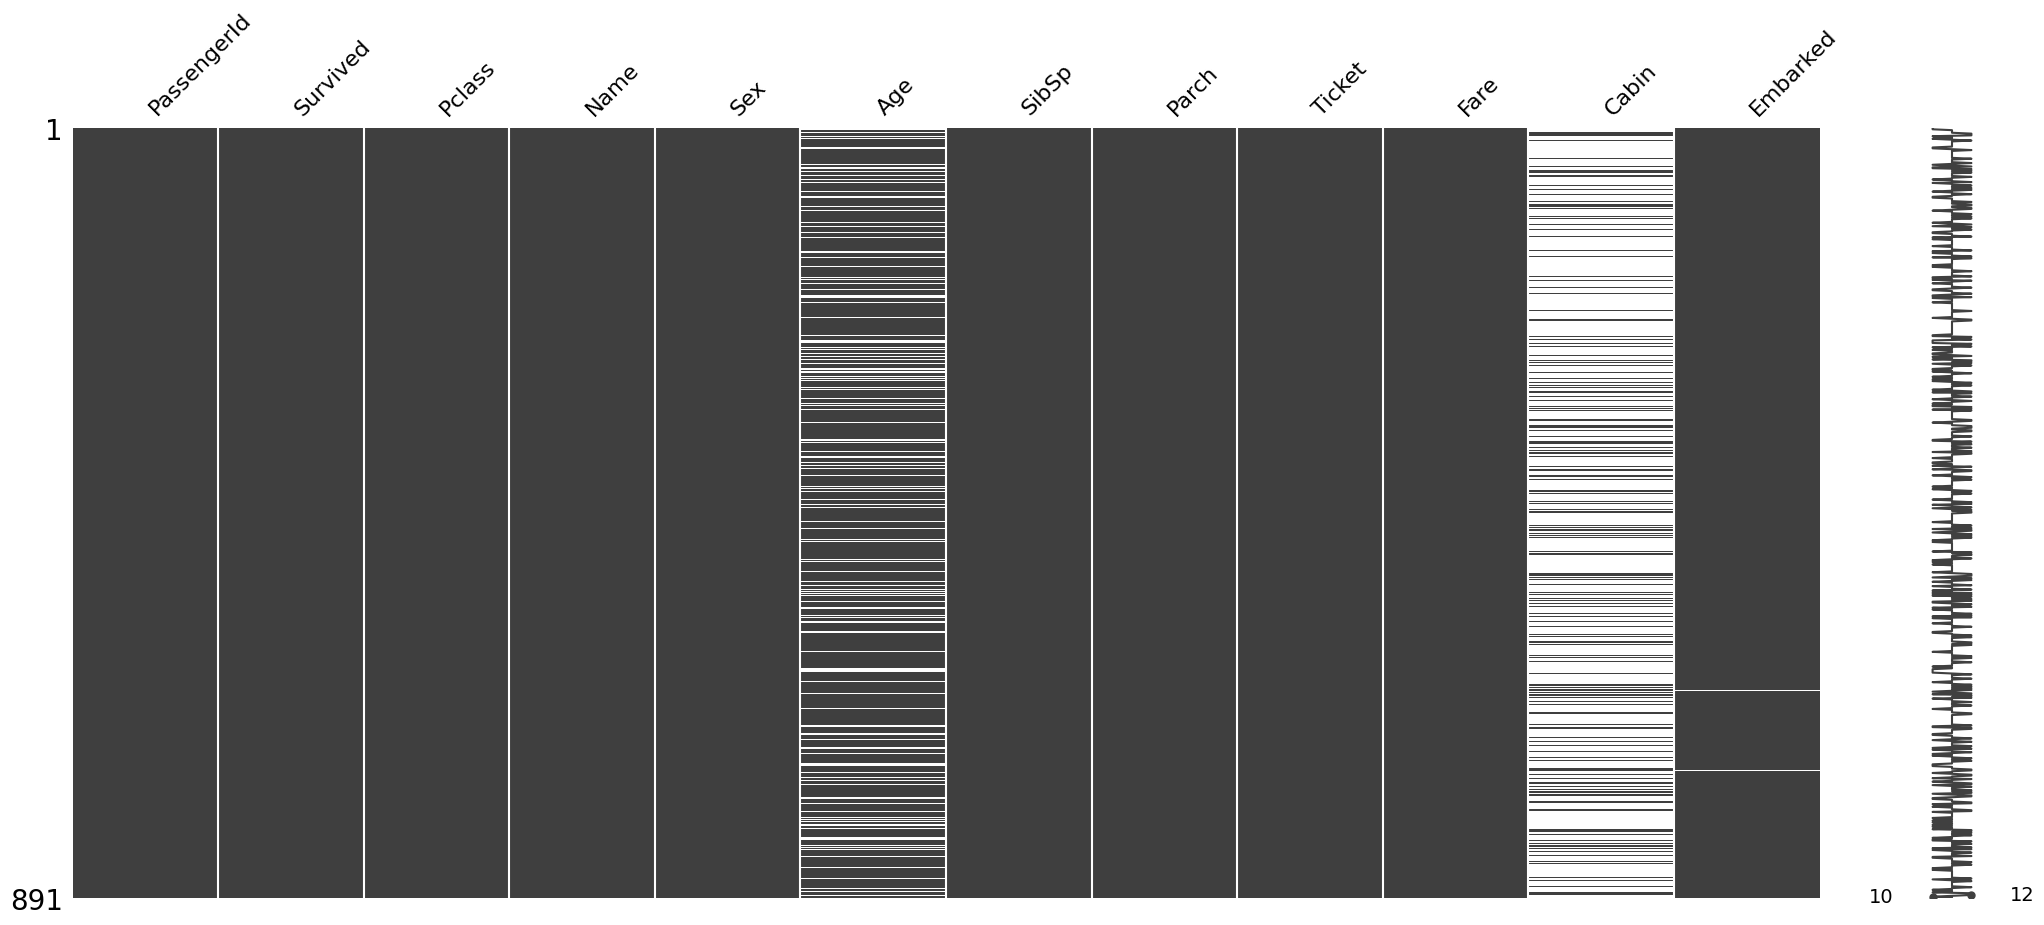

In [18]:
#Visualize character of missing data - Is it regular or random? Train set
ax = msno.matrix(train_data.sample(891))

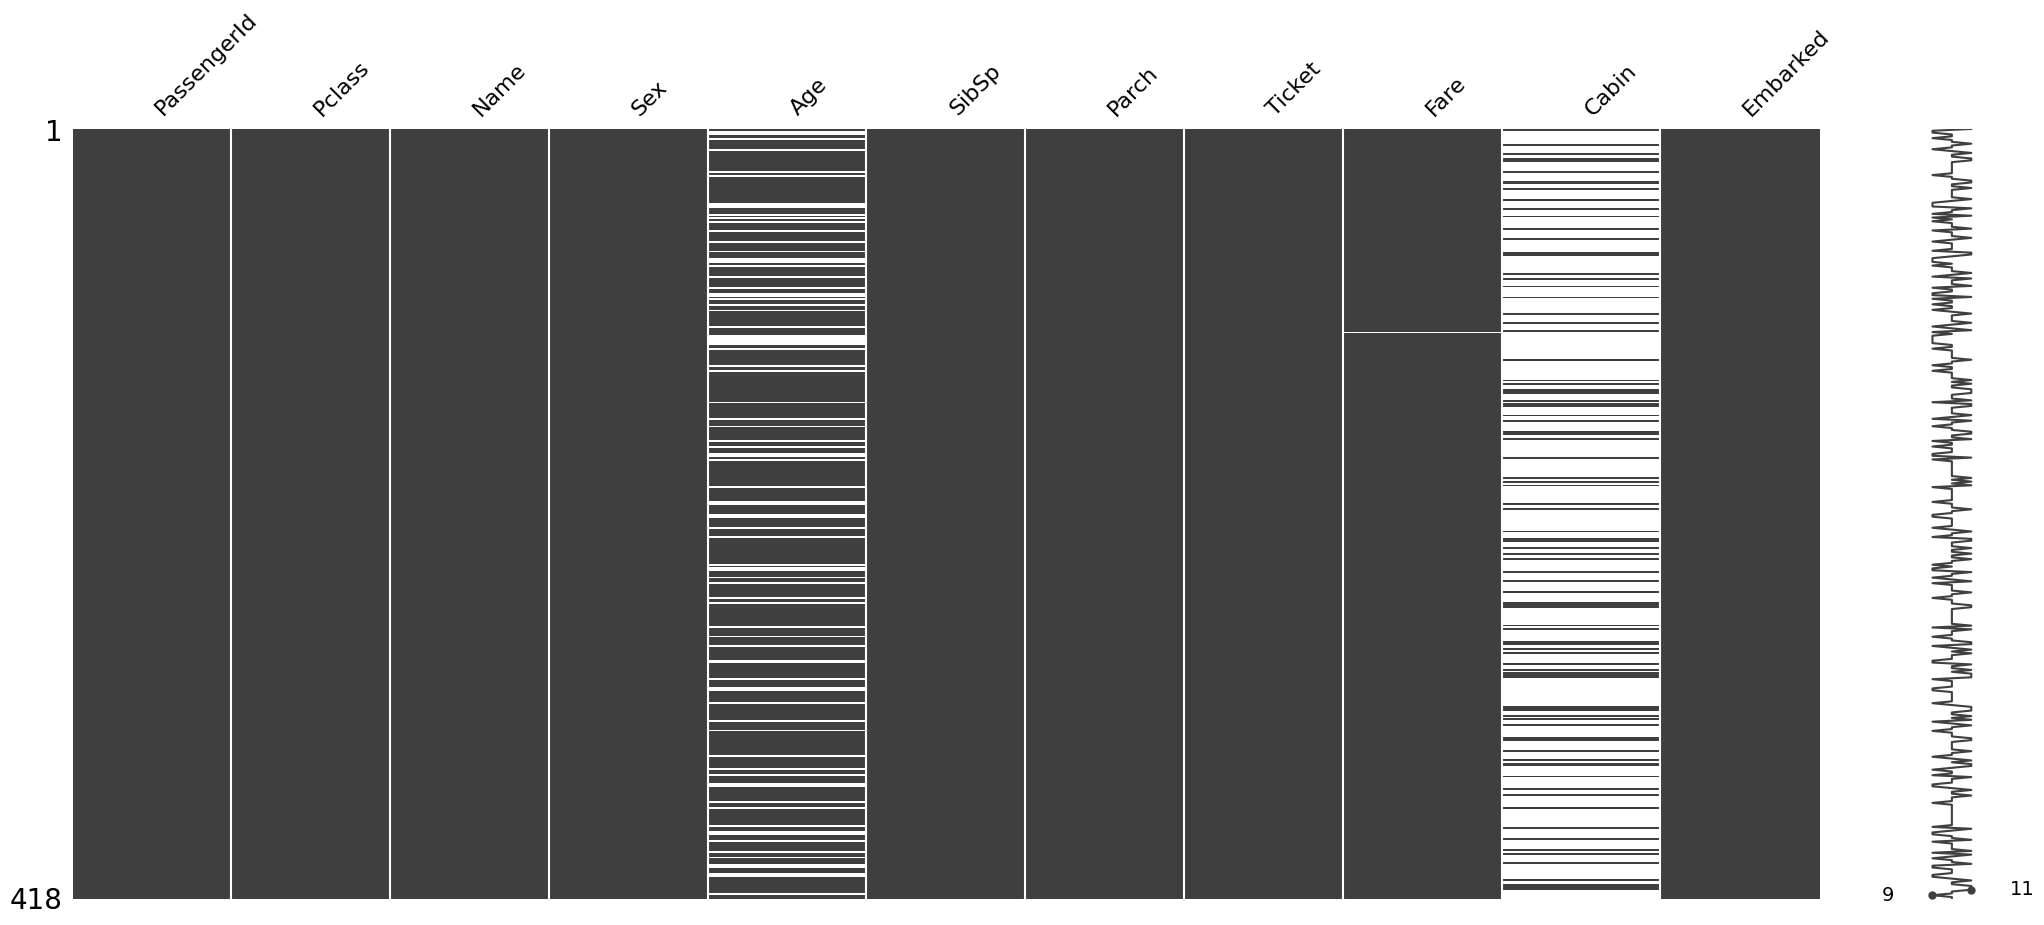

In [19]:
#Visualize character of missing data - Is it regular or random? Test set
ax = msno.matrix(test_data.sample(418))

A picture of missing data without obvious regularities.

In [20]:
#Dealing with missing data - decisions
print("Dealing with missing data.")
print("Delete Cabin column - train data")

train_data = train_data.drop(columns =['Cabin'], axis=1)
train_data.head()

Dealing with missing data.
Delete Cabin column - train data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Decided to delete Cabin column both in train and test set, because in both situations high percentage (above 70%) observed. It will be very hard to fill these empty cells without real data, so "Cabin" column may deteriorate the quality of the model's conclusions

In [21]:
print("Delete Cabin column - test data")

test_data = test_data.drop(columns =['Cabin'], axis=1)
test_data.head()

Delete Cabin column - test data


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [22]:
print("Delete PassengerId column - train data")
train_data = train_data.drop(columns =['PassengerId'], axis=1)
train_data.head()

Delete PassengerId column - train data


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [23]:
print("Delete PassengerId column - test data")
test_data = test_data.drop(columns =['PassengerId'], axis=1)
test_data.head()

Delete PassengerId column - test data


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [24]:
#Analyze variable with unique values 'Ticket', counting duplicates
print("Analyze variable with unique values 'Ticket' in train set, counting duplicates")
len(train_data['Ticket'])-len(train_data['Ticket'].drop_duplicates())

Analyze variable with unique values 'Ticket' in train set, counting duplicates


210

In [25]:
print("Train data shape:",(train_data.shape), "Test data shape:", (test_data.shape))

Train data shape: (891, 10) Test data shape: (418, 9)


In [26]:
#Analyze variable with unique values 'Ticket', counting duplicates
print("Analyze variable with unique values 'Ticket' in test set, counting duplicates")
len(test_data['Ticket'])-len(test_data['Ticket'].drop_duplicates())

Analyze variable with unique values 'Ticket' in test set, counting duplicates


55

In [27]:
print("Train data shape:",(train_data.shape), "Test data shape:", (test_data.shape))

Train data shape: (891, 10) Test data shape: (418, 9)


In [28]:
print("Delete Ticket column - train data")
train_data = train_data.drop(columns =['Ticket'], axis=1)
train_data.head()

Delete Ticket column - train data


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Decided to drop Ticket column in both sets, because data about ticket classes are in Pclass. Also Ticket column has a lot of duplicates.

In [29]:
print("Train data shape:",(train_data.shape), "Test data shape:", (test_data.shape))

Train data shape: (891, 9) Test data shape: (418, 9)


In [30]:
print("Delete Ticket column - test data")
test_data = test_data.drop(columns =['Ticket'], axis=1)
test_data.head()

Delete Ticket column - test data


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [31]:
#Check 
print("Train data shape:",(train_data.shape), "Test data shape:", (test_data.shape))

Train data shape: (891, 9) Test data shape: (418, 8)


It's all correct. Why I deleted these columns:
Ticket - has the same data about classes like Pclass - Pclass it will be
easier to divide by one hot encoding. Also it has a lot of duplicates.
Cabin - this column has to many missing values - it will be hard to fill it
without influence on model fitting.
PassengerId - It's just set of ordinal numbers it does not provide any
important information.
These columns are deleted in both test and train sets.

Visualize Fare distribution in test set


<Axes: title={'center': 'feat1'}, xlabel='Fare'>

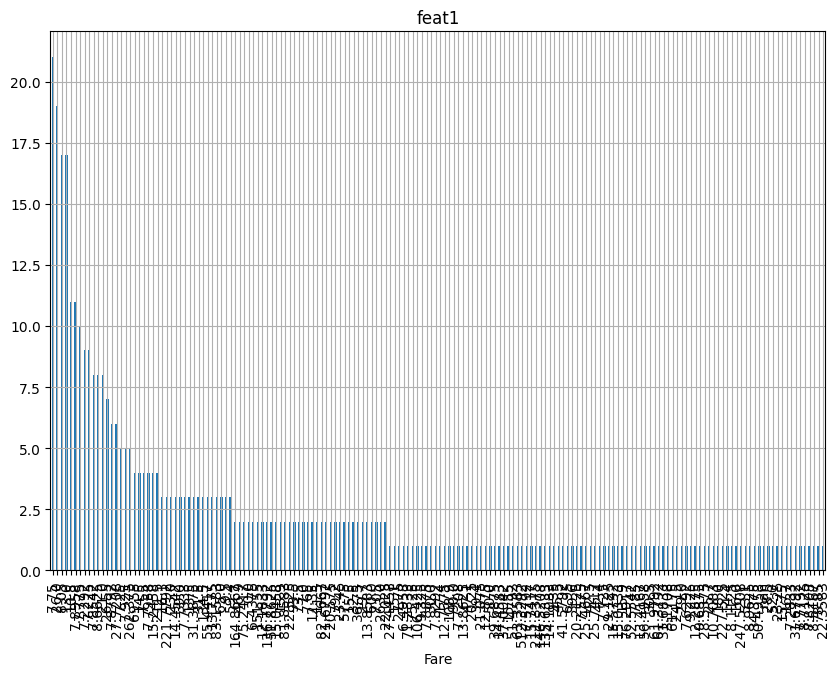

In [32]:
# Dealing with missing data - Fare in test set - analyze feature distribution
print("Visualize Fare distribution in test set")
counts = test_data['Fare'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts.plot.bar(title='feat1', grid=True)

Distribution of this feature doesn't look like normal distribution - 
skewness and kurtosis calculation below.

In [33]:
#Skewness and Kurtosis for Fare in test set
print("Skewness and Kurtosis for Fare in test set")
Fare_test = test_data[['Fare']]

print("Fare data kurtosis - test set\n")        
kurtosis_calc(test_data, Fare_test)
print("\nTest data skewness - test set\n")
skewness_calc(test_data, Fare_test)

Skewness and Kurtosis for Fare in test set
Fare data kurtosis - test set

Fare 17.92159525773599

Test data skewness - test set

Fare 3.6872133081121405


Fare in test set has leptokurtic distribution (thin and tall distribution). That might mean that Fare values have outliers. Also high value of skewness observed, which coincides with the observation from the charts, that Fare distribution in test set is not symmetrical. 

In [34]:
#If fare has ouliers? IQR
print("Interquartlie Range to detect outliers function")

outliers_Fare = IQR_method_detect(test_data['Fare'])
print("number of outliers: "+ str(len(outliers_Fare)))

print("max outlier value: "+ str(outliers_Fare.max()))

print("min outlier value: "+ str(outliers_Fare.min()))


Interquartlie Range to detect outliers function
number of outliers: 55
max outlier value: 512.3292
min outlier value: 69.55


Fare in test set has 55 outliers - median should be used to fill missing values.

In [35]:
#Fill Fare 1 missing value in test set with median

print("Dealing with missing value in Fare column in test set.")
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
test_data.head()

Dealing with missing value in Fare column in test set.


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


Fare filled with median because mean is sensitive to outliers.

In [36]:
test_data.isnull().sum()

Pclass       0
Name         0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64

No missing data in Fare column.

Unique values in Embarked - train


<Axes: xlabel='Embarked'>

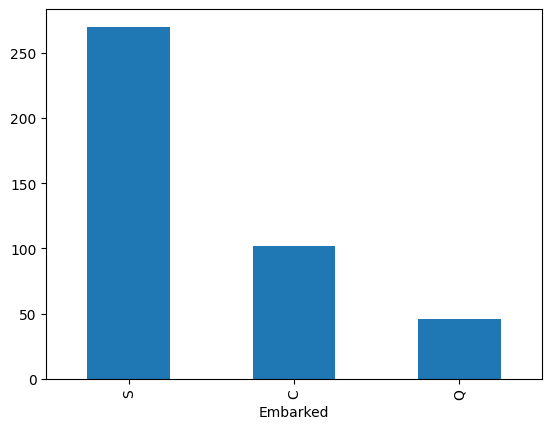

In [37]:
#Dealing with missing data in train set - Embarked- categorical feature
print("Unique values in Embarked - train")
test_data['Embarked'].value_counts().plot(kind='bar')

3 values - one hot encoding will be useful to turn values on numeric variables.

In [38]:
train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [39]:
#Dealing with missing values (2) in Embarked in train set
print("Filling 2 missing values in Embarked train set with most frequent value.")
train_data['Embarked']=train_data['Embarked'].fillna(train_data['Embarked'].value_counts().index[0])
train_data.head()

Filling 2 missing values in Embarked train set with most frequent value.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


I decided to fill 2 missing values with most frequent value "S" - because it is categorical feature.

In [40]:
train_data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

Now Age will be analyzed. In this case I decided to make some deeper analysis, because 177 missing values in train set and 86 missing in test set values observed.

In [41]:
train_data['Sex'] = train_data['Sex'].map({'male':0, 'female':1})
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


In [42]:
test_data['Sex'] = test_data['Sex'].map({'male':0, 'female':1})


Survived turned to numerical variable, because I want use it to calculate correlation with Age.

Visualize Age distribution in train set


<Axes: title={'center': 'feat1'}, xlabel='Age'>

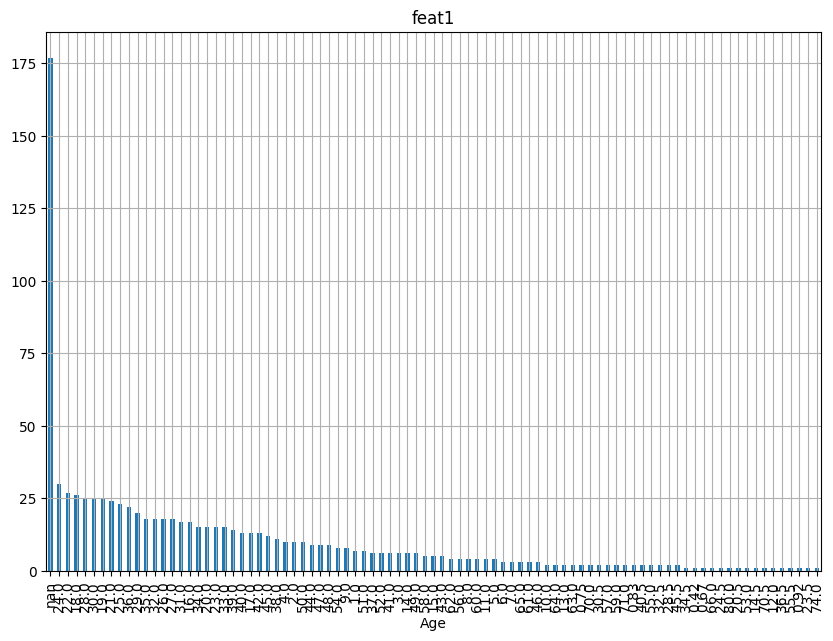

In [43]:
# Dealing with missing data - Age in train set - analyze feature distribution
print("Visualize Age distribution in train set")
counts = train_data['Age'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts.plot.bar(title='feat1', grid=True)

Visualize Age distribution in test set


<Axes: title={'center': 'feat1'}, xlabel='Age'>

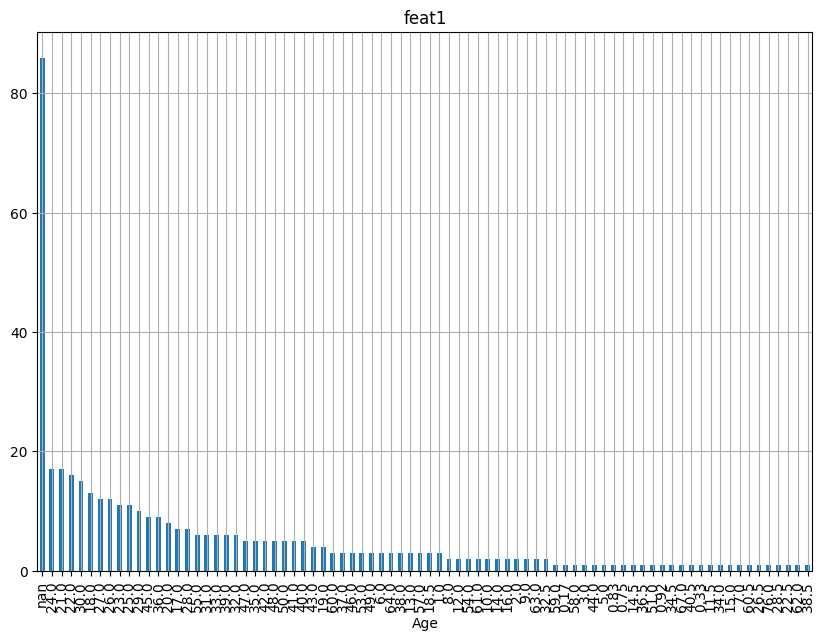

In [44]:
# Dealing with missing data - Fare in test set - analyze feature distribution
print("Visualize Age distribution in test set")
counts1 = test_data['Age'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts1.plot.bar(title='feat1', grid=True)

Observed outliers in Age in test set - decided to fill missing values by median, because mean is sensitive to outliers.

In [45]:
#Skewness and Kurtosis for Age in train set
print("Skewness and Kurtosis for Age in train set\n")

print("Age data kurtosis - train set\n")        
kurtosis_calc(train_data, train_data[['Age']])
print("\nAge data skewness - train set\n")
skewness_calc(train_data, train_data[['Age']])

Skewness and Kurtosis for Age in train set

Age data kurtosis - train set

Age 0.17827415364210353

Age data skewness - train set

Age 0.38910778230082704


In [46]:
#Skewness and Kurtosis for Age in test set
print("Skewness and Kurtosis for Age in test set\n")

print("Age data kurtosis - test set\n")        
kurtosis_calc(test_data, test_data[['Age']])
print("\nAge data skewness - test set\n")
skewness_calc(test_data, test_data[['Age']])

Skewness and Kurtosis for Age in test set

Age data kurtosis - test set

Age 0.08378335153796135

Age data skewness - test set

Age 0.4573612871503845


Data are moderately skewed.
Low kurtosis in a data set is an indicator that data has lack of outliers.
Despite this results I will use IQR method, because Age has a lot of missing values, it could have influence of this results.


In [47]:
IQR_method_detect(train_data['Age'])

outliers_Age = IQR_method_detect(train_data['Age'])
print("number of outliers: "+ str(len(outliers_Age)))

print("max outlier value: "+ str(outliers_Age.max()))

print("min outlier value: "+ str(outliers_Age.min()))

number of outliers: 11
max outlier value: 80.0
min outlier value: 65.0


In [48]:
IQR_method_detect(test_data['Age'])

outliers_Age_test = IQR_method_detect(test_data['Age'])
print("number of outliers: "+ str(len(outliers_Age_test)))

print("max outlier value: "+ str(outliers_Age_test.max()))

print("min outlier value: "+ str(outliers_Age_test.min()))

number of outliers: 2
max outlier value: 76.0
min outlier value: 67.0


Despite results using skewness and kurtosis values, IQR method shows 11 
outliers. That's why I will be using median to fill missing values in Age. In test set only 2 outliers observed, but it could be remembered that test set 
includes less data and it should be treated the same, because it will be
represent bahavior of training set.

In [49]:
#Finding correlations with Age, because Age has so many missing values
print("Correlation between numeric values vs Age - train set")
matrix_corrs = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr()
matrix_corrs

Correlation between numeric values vs Age - train set


,Pclass,Sex,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333
Age,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000


Visualisation of correlation between numeric values vs Age - train set


<Axes: >

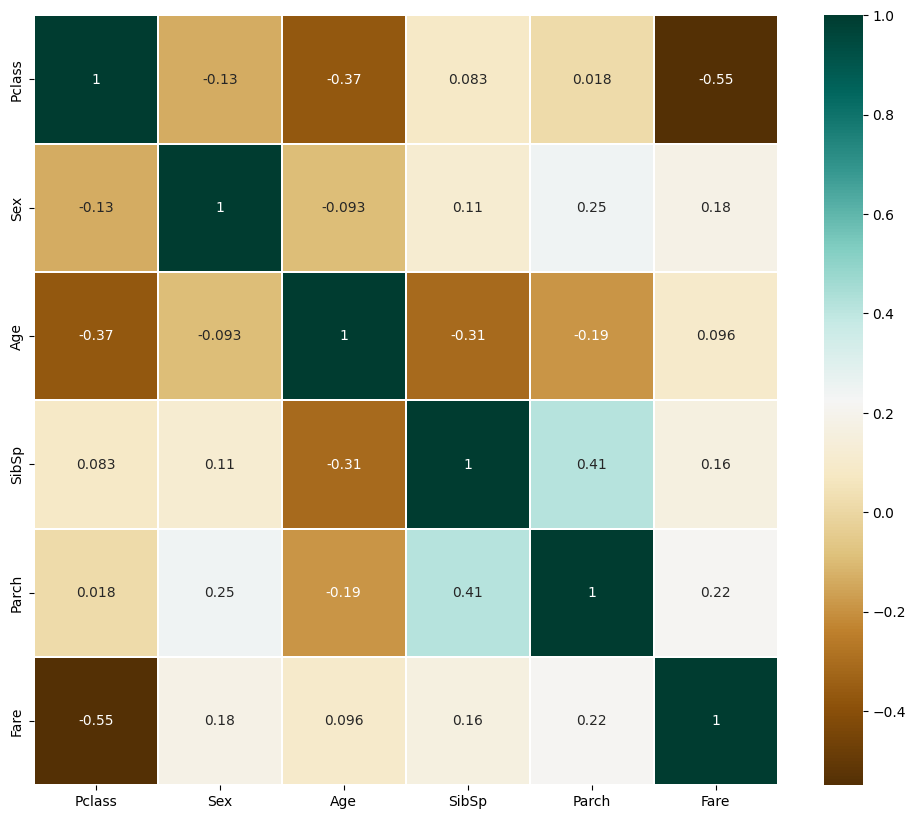

In [50]:
print("Visualisation of correlation between numeric values vs Age - train set")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

Pclass(-0.37), SibSp(-0.31) - they are negatively correlated with Age (medium strength). I decided that other variables have to small strength of correlation with Age. I'll expand further analysis of SibSp and Pclass

In [51]:
#Calculate the mean and median of Age it will be useful to get some comparisons to 
#find the best method to fill a lot of missing values in this column.
print("Age - Mean and Median - train set.")
print(train_data.Age.mean())
print(train_data.Age.median())

Age - Mean and Median - train set.
29.69911764705882
28.0


In [52]:
print("Age - Mean and Median - test set.")
print(test_data.Age.mean())
print(test_data.Age.median())

Age - Mean and Median - test set.
30.272590361445783
27.0


In [53]:
#Trying to find pattern to fill missing values in Age
age_groupby_pclass = train_data.groupby(['Pclass']).Age.agg([len, min, max, 'mean', 'median'])
age_groupby_pclass

,len,min,max,mean,median
Pclass,,,,,
1,216,0.92,80.0,38.233441,37.0
2,184,0.67,70.0,29.877630,29.0
3,491,0.42,74.0,25.140620,24.0


In [54]:
age_groupby_pclass_test = test_data.groupby(['Pclass']).Age.agg([len, min, max, 'mean', 'median'])
age_groupby_pclass_test

,len,min,max,mean,median
Pclass,,,,,
1,107,6.00,76.0,40.918367,42.0
2,93,0.92,63.0,28.777500,26.5
3,218,0.17,60.5,24.027945,24.0


In [55]:
#Trying to find pattern to fill missing values in Age
age_groupby_sibsp = train_data.groupby(['SibSp']).Age.agg([len, min, max, 'mean', 'median'])
age_groupby_sibsp

,len,min,max,mean,median
SibSp,,,,,
0,608,0.42,80.0,31.397558,29.0
1,209,0.67,70.0,30.089727,30.0
2,28,0.75,53.0,22.620000,23.0
3,16,2.00,33.0,13.916667,9.5
4,18,1.00,17.0,7.055556,6.5
5,5,1.00,16.0,10.200000,11.0
8,7,NaN,NaN,NaN,NaN


In [56]:
age_groupby_sibsp_test = test_data.groupby(['SibSp']).Age.agg([len, min, max, 'mean', 'median'])
age_groupby_sibsp_test

,len,min,max,mean,median
SibSp,,,,,
0,283,0.33,64.0,29.874579,27.0
1,110,0.17,76.0,32.884948,30.0
2,14,12.00,59.0,25.727273,21.0
3,4,6.00,31.0,23.500000,28.5
4,4,5.00,38.0,16.500000,11.5
5,1,10.00,10.0,10.000000,10.0
8,2,14.50,14.5,14.500000,14.5


In [57]:
(train_data.groupby(['Pclass', 'SibSp']))['Age'].median()

Pclass  SibSp
1       0        37.0
        1        38.0
        2        44.0
        3        23.0
2       0        30.0
        1        29.0
        2        23.5
        3        30.0
3       0        26.0
        1        25.0
        2        19.5
        3         6.0
        4         6.5
        5        11.0
        8         NaN
Name: Age, dtype: float64

In [58]:
train_data.groupby(['Pclass', 'SibSp'])['Age'].describe()

count       mean        std    min    25%   50%    75%   max
Pclass SibSp                                                              
1      0      113.0  39.181416  14.844591   4.00  28.00  37.0  50.00  80.0
       1       65.0  37.414154  14.690355   0.92  28.00  38.0  49.00  70.0
       2        5.0  37.200000  16.513631  18.00  21.00  44.0  50.00  53.0
       3        3.0  22.000000   2.645751  19.00  21.00  23.0  23.50  24.0
2      0      109.0  31.934220  13.486824   0.83  23.00  30.0  39.00  70.0
       1       55.0  27.363636  14.609811   0.67  21.50  29.0  35.00  60.0
       2        8.0  19.125000  10.776131   1.00  16.75  23.5  24.00  32.0
       3        1.0  30.000000        NaN  30.00  30.00  30.0  30.00  30.0
3      0      249.0  27.630201  11.501377   0.42  20.00  26.0  33.00  74.0
       1       63.0  24.912698  11.439018   1.00  17.50  25.0  32.50  48.0
       2       12.0  18.875000  13.276560   0.75   8.00  19.5  26.50  41.0
       3        8.0   8.875000  10.260013   2.00   2.75   6.0   9.25  33.0
       4       18.0   7.055556   4.880601   1.00   3.25   6.5   9.00  17.0
       5        5.0  10.200000   5.805170   1.00   9.00  11.0  14.00  16.0
       8        0.0        NaN        NaN    NaN    NaN   NaN    NaN   NaN

In [59]:
missing_Age = train_data[train_data['Age'].isnull()]
median_Age_grouped_train = train_data.groupby(['Pclass','SibSp'])['Age'].median()

def Age_filled(feature):
    if pd.isnull(feature['Age']):
        return median_Age_grouped_train[feature['Pclass'],feature['SibSp']]
    else:
        return feature['Age']

train_data['Age'] = train_data.apply(Age_filled, axis=1)

In [60]:
train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         7
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [61]:
train_data['Age']=train_data['Age'].replace(np.nan, 26.0)
train_data.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,13.00,S
887,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,30.00,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,25.0,1,2,23.45,S
889,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,30.00,C
890,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,7.75,Q


I've tried different ways, functions but always I've got 7 missing values, so
I fill these gaps with calculate median by replace method.

In [62]:
train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [63]:
test_data['Age'] = test_data.apply(Age_filled, axis=1)
test_data.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         1
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [64]:
test_data['Age'] = test_data['Age'].replace(np.nan, 26.0)
test_data.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [65]:
categorical_var_train = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_var_test = test_data.select_dtypes(include=['object']).columns.tolist()
numerical_var_train = train_data.select_dtypes(include=['int','float']).columns.tolist()
numerical_var_test = test_data.select_dtypes(include=['int', 'float']).columns.tolist()
print("\nCategorical features-train\n")
print(categorical_var_train)
print("\nNumerical features-train\n")
print(numerical_var_train)
print("\nCategorical features-test\n")
print(categorical_var_test)
print("\nNumerical features-test\n")
print(numerical_var_test)


Categorical features-train

['Name', 'Embarked']

Numerical features-train

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical features-test

['Name', 'Embarked']

Numerical features-test

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


In [66]:
#Dealing with outliers - numeric features

print("Fare data kurtosis - train set\n")        
kurtosis_calc(train_data, numerical_var_train)

Fare data kurtosis - train set

Survived -1.775004671066304
Pclass -1.2800149715782825
Sex -1.620579701569441
Age 0.7769782521156281
SibSp 17.880419726645968
Parch 9.778125179021648
Fare 33.39814088089868


Conclusions: SibSp, Parch, Fare have high value of kurtosis - these features will go to deeper outliers analysis.

In [67]:
#Dealing with outliers - numeric features

print("Fare data kurtosis - test set\n")        
kurtosis_calc(test_data, numerical_var_test)

Fare data kurtosis - test set

Pclass -1.3826663845898164
Sex -1.6843317638686617
Age 0.7908437922783125
SibSp 26.498712128269855
Parch 31.41251290547421
Fare 17.970402003319332


Conclusions: SibSp, Parch, Fare have high value of kurtosis - these features will go to deeper outliers analysis.

Visualize Fare distribution in train set


<Axes: title={'center': 'feat1'}, xlabel='Fare'>

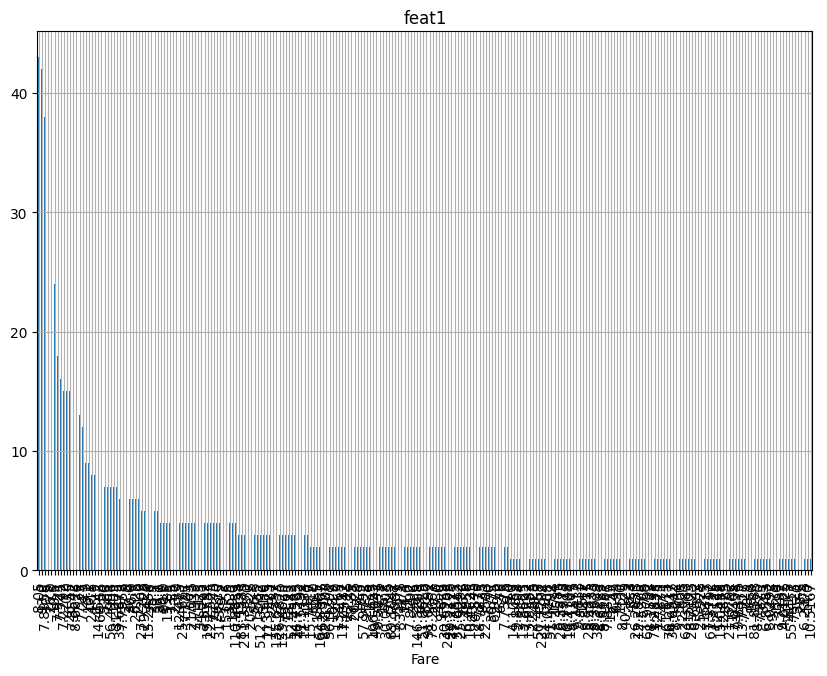

In [68]:
print("Visualize Fare distribution in train set")
counts = train_data['Fare'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts.plot.bar(title='feat1', grid=True)

Visualize SibSp distribution in train set


<Axes: title={'center': 'feat1'}, xlabel='SibSp'>

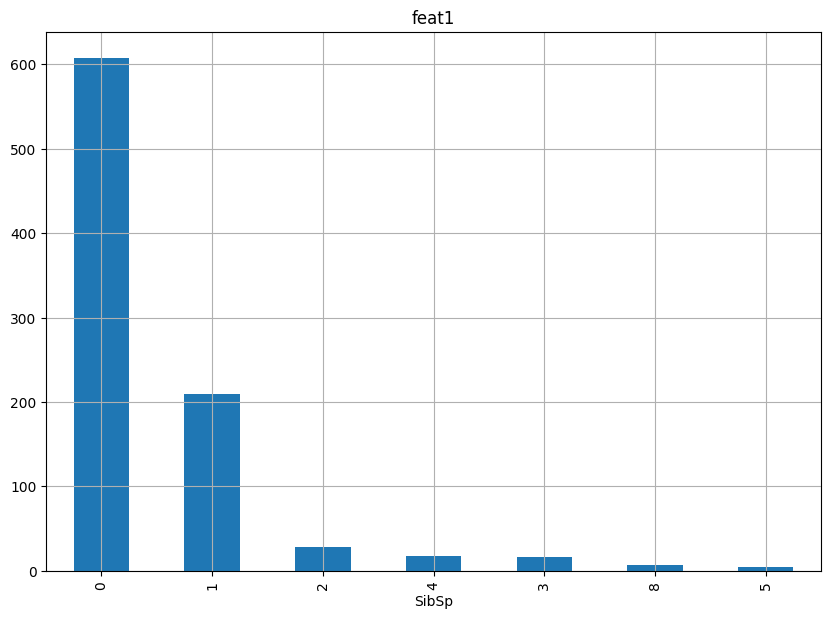

In [69]:
print("Visualize SibSp distribution in train set")
counts = train_data['SibSp'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts.plot.bar(title='feat1', grid=True)

Visualize Parch distribution in train set


<Axes: title={'center': 'feat1'}, xlabel='Parch'>

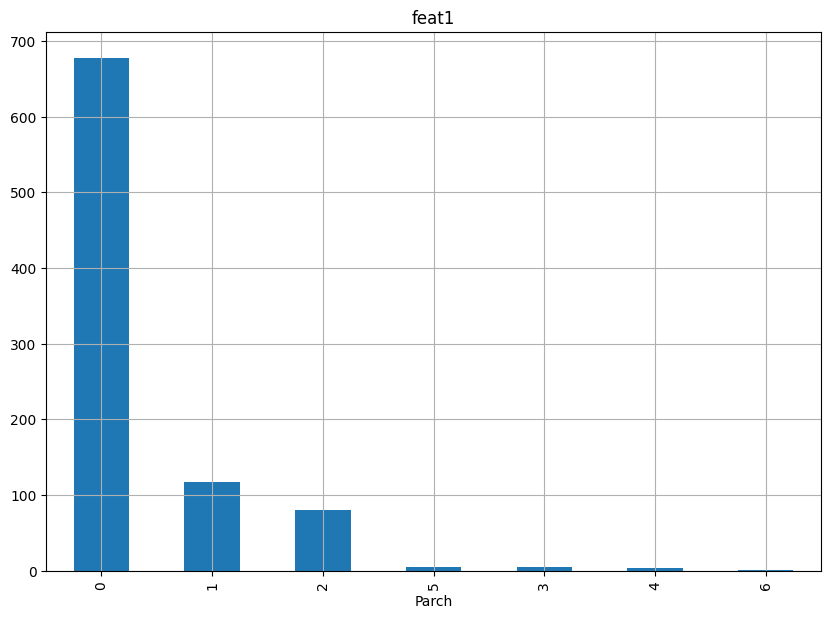

In [70]:
# Dealing with missing data - Fare in test set - analyze feature distribution
print("Visualize Parch distribution in train set")
counts = train_data['Parch'].value_counts(dropna=False)
fig = plt.figure(figsize =(10, 7))
counts.plot.bar(title='feat1', grid=True)

In [71]:
print("Interquartlie Range to detect outliers in SibSp train set")

outliers_SibSp_train = IQR_method_detect(train_data['SibSp'])
print("number of outliers: "+ str(len(outliers_SibSp_train)))

print("max outlier value: "+ str(outliers_SibSp_train.max()))

print("min outlier value: "+ str(outliers_SibSp_train.min()))

Interquartlie Range to detect outliers in SibSp train set
number of outliers: 46
max outlier value: 8
min outlier value: 3


In [72]:
print("Interquartlie Range to detect outliers in Pclass train set")

outliers_SibSp_train = IQR_method_detect(train_data['Pclass'])
print("number of outliers: "+ str(len(outliers_SibSp_train)))

print("max outlier value: "+ str(outliers_SibSp_train.max()))

print("min outlier value: "+ str(outliers_SibSp_train.min()))

Interquartlie Range to detect outliers in Pclass train set
number of outliers: 0
max outlier value: nan
min outlier value: nan


Check if IQR method is right - in this case it is correct method to detect outliers.

In [73]:
print("Interquartlie Range to detect outliers in SibSp test set")

outliers_SibSp_test = IQR_method_detect(test_data['SibSp'])
print("number of outliers: "+ str(len(outliers_SibSp_test)))

print("max outlier value: "+ str(outliers_SibSp_test.max()))

print("min outlier value: "+ str(outliers_SibSp_test.min()))

Interquartlie Range to detect outliers in SibSp test set
number of outliers: 11
max outlier value: 8
min outlier value: 3


In [74]:
print("Interquartlie Range to detect outliers in Parch train set")

outliers_Parch_train = IQR_method_detect(train_data['Parch'])
print("number of outliers: "+ str(len(outliers_Parch_train)))

print("max outlier value: "+ str(outliers_Parch_train.max()))

print("min outlier value: "+ str(outliers_Parch_train.min()))

Interquartlie Range to detect outliers in Parch train set
number of outliers: 213
max outlier value: 6
min outlier value: 1


In [75]:
print("Interquartlie Range to detect outliers in Parch test set")

outliers_Parch_test = IQR_method_detect(test_data['Parch'])
print("number of outliers: "+ str(len(outliers_Parch_test)))

print("max outlier value: "+ str(outliers_Parch_test.max()))

print("min outlier value: "+ str(outliers_Parch_test.min()))

Interquartlie Range to detect outliers in Parch test set
number of outliers: 94
max outlier value: 9
min outlier value: 1


In [76]:
print("Interquartlie Range to detect outliers in Fare train set")

outliers_Fare_train = IQR_method_detect(train_data['Fare'])
print("number of outliers: "+ str(len(outliers_Fare_train)))

print("max outlier value: "+ str(outliers_Fare_train.max()))

print("min outlier value: "+ str(outliers_Fare_train.min()))

Interquartlie Range to detect outliers in Fare train set
number of outliers: 116
max outlier value: 512.3292
min outlier value: 66.6


These calculations show that these features have problem with outliers in
both sets. These outliers should be deleted. Fare test also has oulliers - it was calculated above.

In [77]:
# OneHotEncoder
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Embarked'].values.reshape(-1, 1)))
train_data[['Embarked - Cherbourg', 'Embarked - Queenstown', 'Embarked - Southampton']] = pd.DataFrame(result, index = train_data.index)


train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,0.0,1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,0.0,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,0.0,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,0.0,1.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,0.0,1.0


In [78]:
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Embarked'].values.reshape(-1, 1)))
test_data[['Embarked - Cherbourg', 'Embarked - Queenstown', 'Embarked - Southampton']] = pd.DataFrame(result, index = test_data.index)


test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,1.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,0.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,1.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,1.0


In [79]:
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Sex'].values.reshape(-1, 1)))
train_data[['Female', 'Male']] = pd.DataFrame(result, index = train_data.index)

train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,Female,Male
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,0.0,1.0,1.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,0.0,0.0,0.0,1.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,0.0,1.0,0.0,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,0.0,1.0,0.0,1.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,0.0,1.0,1.0,0.0


In [80]:
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Sex'].values.reshape(-1, 1)))
test_data[['Female', 'Male']] = pd.DataFrame(result, index = test_data.index)

test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,Female,Male
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,0.0,1.0,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,1.0,0.0,1.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,0.0,1.0,0.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,1.0,1.0,0.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,1.0,0.0,1.0


In [81]:
print("One Hot Encoding for Pclass - better understanding of class (socio-economic status) meaning in model.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Pclass'].values.reshape(-1, 1)))
train_data[['1st class', '2nd class', '3rd class']] = pd.DataFrame(result, index = train_data.index)

train_data.head()

One Hot Encoding for Pclass - better understanding of class (socio-economic status) meaning in model.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,Female,Male,1st class,2nd class,3rd class
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [82]:
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Pclass'].values.reshape(-1, 1)))
test_data[['1st class', '2nd class', '3rd class']] = pd.DataFrame(result, index = test_data.index)

test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,Female,Male,1st class,2nd class,3rd class
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [83]:
#Extracting title from name and use One Hot Encoding to turn it to numeric variable
print("Feature engineering")
print("Extracting Title from Name in train set.")
# create a new feature to extract title names from the Name column
train_data['Title'] = train_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
Dict_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
# map titles and view value frequency
train_data.Title = train_data.Title.map(Dict_titles)
print(train_data.Title.value_counts())

Feature engineering
Extracting Title from Name in train set.
Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64


Even though more women survived, there were more men in the ship. And 6 unique values observed - it will be One Hot Encoding in use.

In [84]:
#Extracting title from name and use One Hot Encoding to turn it to numeric variable
print("Feature engineering")
print("Extracting Title from Name in test set.")
# create a new feature to extract title names from the Name column
test_data['Title'] = test_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
Dict_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
# map titles and view value frequency
test_data.Title = test_data.Title.map(Dict_titles)
print(test_data.Title.value_counts())

Feature engineering
Extracting Title from Name in test set.
Title
Mr         240
Miss        78
Mrs         73
Master      21
Officer      5
Royalty      1
Name: count, dtype: int64


In [85]:
# OneHotEncoder
print("Change Title to numerical features in train set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Title'].values.reshape(-1, 1)))

train_data[['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty']] = pd.DataFrame(result, index = train_data.index)
train_data.head()

Change Title to numerical features in train set.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,1st class,2nd class,3rd class,Title,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0.0,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,1.0,0.0,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,0.0,0.0,1.0,Miss,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,1.0,0.0,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,0.0,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0


In [86]:
# OneHotEncoder
print("Change Title to numerical features in test set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Title'].values.reshape(-1, 1)))

test_data[['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty']] = pd.DataFrame(result, index = test_data.index)
test_data.head()

Change Title to numerical features in test set.


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,1st class,2nd class,3rd class,Title,Master,Miss,Mr,Mrs,Officer,Royalty
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,0.0,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,0.0,0.0,1.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,0.0,1.0,0.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,0.0,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,0.0,0.0,1.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0


In [87]:
#Combine Parch i SibSp - create new feature
print("Create Family Size - new feature by combining Parch i SibSp in train and test set")

train_data['Family Size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Family Size'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data.head()

Create Family Size - new feature by combining Parch i SibSp in train and test set


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,2nd class,3rd class,Title,Master,Miss,Mr,Mrs,Officer,Royalty,Family Size
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,0.0,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,0.0,1.0,Miss,0.0,1.0,0.0,0.0,0.0,0.0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,0.0,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0,2
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,0.0,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0,1


In [88]:
train_data['Is_Alone'] = 0
train_data.loc[train_data['Family Size'] == 1, 'Is_Alone'] = 1
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,3rd class,Title,Master,Miss,Mr,Mrs,Officer,Royalty,Family Size,Is_Alone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0,2,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,1.0,Miss,0.0,1.0,0.0,0.0,0.0,0.0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,0.0,Mrs,0.0,0.0,0.0,1.0,0.0,0.0,2,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,1.0,Mr,0.0,0.0,1.0,0.0,0.0,0.0,1,1


In [89]:
test_data['Is_Alone'] = 0
test_data.loc[test_data['Family Size'] == 1, 'Is_Alone'] = 1

In [90]:
# OneHotEncoder
print("Change Title to numerical features in test set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Is_Alone'].values.reshape(-1, 1)))


test_data[['With someone', 'Alone']] = pd.DataFrame(result, index = test_data.index)
test_data.head()

Change Title to numerical features in test set.


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Master,Miss,Mr,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3,0,1.0,0.0


In [91]:
# OneHotEncoder
print("Change Title to numerical features in test set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Is_Alone'].values.reshape(-1, 1)))


train_data[['With someone', 'Alone']] = pd.DataFrame(result, index = train_data.index)
train_data.head()

Change Title to numerical features in test set.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,Master,Miss,Mr,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2,0,1.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0


In [92]:
print("Couples")
train_data['Is_Couple'] = 0
train_data.loc[train_data['Title'] == 'Mrs', 'Is_Couple'] = 1
#train_data['Is_Couple'] = train_data['Is_Couple'].loc[train_data['Title'] == 'Mrs'] = 1
train_data.head()

Couples


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,Miss,Mr,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone,Is_Couple
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0.0,1.0,0.0,0.0,0.0,2,0,1.0,0.0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,1.0,0.0,0.0,0.0,0.0,1,1,0.0,1.0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0,1
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0,0


In [93]:
print("Couples")
test_data['Is_Couple'] = 0
test_data.loc[test_data['Title'] == 'Mrs', 'Is_Couple'] = 1
#train_data['Is_Couple'] = train_data['Is_Couple'].loc[train_data['Title'] == 'Mrs'] = 1
test_data.head()

Couples


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Miss,Mr,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone,Is_Couple
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2,0,1.0,0.0,1
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0,0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,1,0.0,1.0,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3,0,1.0,0.0,1


In [94]:
# OneHotEncoder
print("Change Title to numerical features in test set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Is_Couple'].values.reshape(-1, 1)))

test_data[['Couple', 'NotCouple']] = pd.DataFrame(result, index = test_data.index)
test_data.head()

Change Title to numerical features in test set.


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,0.0,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,1.0,0.0,0.0,2,0,1.0,0.0,1,0.0,1.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,0.0,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,0.0,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,1.0,0.0,0.0,3,0,1.0,0.0,1,0.0,1.0


In [95]:
# OneHotEncoder
print("Change Title to numerical features in test set.")
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Is_Couple'].values.reshape(-1, 1)))

train_data[['Couple', 'NotCouple']] = pd.DataFrame(result, index = train_data.index)
train_data.head()

Change Title to numerical features in test set.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,Mrs,Officer,Royalty,Family Size,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0.0,0.0,0.0,2,0,1.0,0.0,0,1.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,1.0,0.0,0.0,2,0,1.0,0.0,1,0.0,1.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,0.0,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,1.0,0.0,0.0,2,0,1.0,0.0,1,0.0,1.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,0.0,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0


In [96]:
bins = np.linspace(min(train_data['Age']), max(train_data['Age']), 4)
group_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
group_names = {'child': 0-18, 'adult': 19-60, 'senior': 60-79}

train_data['Age-binned'] = pd.cut(train_data['Age'], bins, labels=group_names, include_lowest=True )
train_data[['Age','Age-binned']].head()

,Age,Age-binned
0,22.0,child
1,38.0,adult
2,26.0,child
3,35.0,adult
4,35.0,adult


In [97]:
bins = np.linspace(min(test_data['Age']), max(test_data['Age']), 4)
group_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
group_names = {'child': 0-18, 'adult': 19-60, 'senior': 60-79}

test_data['Age-binned'] = pd.cut(test_data['Age'], bins, labels=group_names, include_lowest=True )
test_data[['Age','Age-binned']].head()

,Age,Age-binned
0,34.5,adult
1,47.0,adult
2,62.0,senior
3,27.0,adult
4,22.0,child


In [98]:
# OneHotEncoder
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(train_data['Age-binned'].values.reshape(-1, 1)))

train_data[['Child', 'Adult', 'Senior']] = pd.DataFrame(result, index = train_data.index)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,...,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple,Age-binned,Child,Adult,Senior
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,...,0,1.0,0.0,0,1.0,0.0,child,0.0,1.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,...,0,1.0,0.0,1,0.0,1.0,adult,1.0,0.0,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,...,1,0.0,1.0,0,1.0,0.0,child,0.0,1.0,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,...,0,1.0,0.0,1,0.0,1.0,adult,1.0,0.0,0.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,...,1,0.0,1.0,0,1.0,0.0,adult,1.0,0.0,0.0


In [99]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Officer,Royalty,Family Size,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple,Age-binned
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0,adult
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,0.0,0.0,2,0,1.0,0.0,1,0.0,1.0,adult
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0,senior
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,0.0,0.0,1,1,0.0,1.0,0,1.0,0.0,adult
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,0.0,0.0,3,0,1.0,0.0,1,0.0,1.0,child


In [100]:
# OneHotEncoder for encoding Embarked in train and test set
result = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(test_data['Age-binned'].values.reshape(-1, 1)))
test_data[['Child', 'Adult', 'Senior']] = pd.DataFrame(result, index = test_data.index)


test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple,Age-binned,Child,Adult,Senior
0,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,Q,0.0,1.0,...,1,0.0,1.0,0,1.0,0.0,adult,1.0,0.0,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,S,0.0,0.0,...,0,1.0,0.0,1,0.0,1.0,adult,1.0,0.0,0.0
2,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,Q,0.0,1.0,...,1,0.0,1.0,0,1.0,0.0,senior,0.0,0.0,1.0
3,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,S,0.0,0.0,...,1,0.0,1.0,0,1.0,0.0,adult,1.0,0.0,0.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,S,0.0,0.0,...,0,1.0,0.0,1,0.0,1.0,child,0.0,1.0,0.0


In [101]:
print("Delete unnecessary columns - train data.")

train_data = train_data.drop(columns =['Name'], axis=1)
train_data.head()

Delete unnecessary columns - train data.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked - Cherbourg,Embarked - Queenstown,...,Is_Alone,With someone,Alone,Is_Couple,Couple,NotCouple,Age-binned,Child,Adult,Senior
0,0,3,0,22.0,1,0,7.2500,S,0.0,0.0,...,0,1.0,0.0,0,1.0,0.0,child,0.0,1.0,0.0
1,1,1,1,38.0,1,0,71.2833,C,1.0,0.0,...,0,1.0,0.0,1,0.0,1.0,adult,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,S,0.0,0.0,...,1,0.0,1.0,0,1.0,0.0,child,0.0,1.0,0.0
3,1,1,1,35.0,1,0,53.1000,S,0.0,0.0,...,0,1.0,0.0,1,0.0,1.0,adult,1.0,0.0,0.0
4,0,3,0,35.0,0,0,8.0500,S,0.0,0.0,...,1,0.0,1.0,0,1.0,0.0,adult,1.0,0.0,0.0


In [102]:
print("Delete unnecessary columns - train data.")

train_data = train_data.drop(columns =['Embarked', 'Age-binned', 'Is_Alone', 'Is_Couple', 'NotCouple', 'Title'], axis=1)
train_data.head()

Delete unnecessary columns - train data.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,...,Mrs,Officer,Royalty,Family Size,With someone,Alone,Couple,Child,Adult,Senior
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0,...,0.0,0.0,0.0,2,1.0,0.0,1.0,0.0,1.0,0.0
1,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,...,1.0,0.0,0.0,2,1.0,0.0,0.0,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0,...,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,1.0,0.0
3,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,...,1.0,0.0,0.0,2,1.0,0.0,0.0,1.0,0.0,0.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0,...,0.0,0.0,0.0,1,0.0,1.0,1.0,1.0,0.0,0.0


As shown above train and test set still have categorical features. I deleted these column, because I changed both these columns values to numerical.

In [103]:
print("Delete unnecessary columns - train data.")

test_data = test_data.drop(columns =['Name'], axis=1)

Delete unnecessary columns - train data.


In [104]:
print("Delete unnecessary columns - train data.")

test_data = test_data.drop(columns =['Embarked', 'Age-binned', 'Is_Alone', 'Is_Couple', 'NotCouple', 'Title'], axis=1)


Delete unnecessary columns - train data.


In [105]:
num_vares = train_data.select_dtypes(include=['int','float']).columns.tolist()


In [106]:
num_vares_test = train_data.select_dtypes(include=['int','float']).columns.tolist()

In [107]:
def ploters(variables, df):
    fig, axes = plt.subplots(10,3, figsize=(8, 30))
    flattened_axes = fig.axes
    

    for i, var in enumerate(variables):
        ax = flattened_axes[i]
        i = np.array([i])
        sns.regplot(x=var, y='Survived', data=df, ax=ax,)

    plt.show()

In [108]:
#Analyze selected numerical features (without PassengerId)
print("Visualization to explore numerical features")


def multiple_histograms(df, features, rows, cols):
    figure=plt.figure()
    figure, axes = plt.subplots(10,3, figsize=(15, 15))
    flattened_axes = fig.axes
    
    for i, feat in enumerate(features):
        ax=figure.add_subplot(rows,cols,i+1)
        df[feat].hist(bins=10,ax=ax)
        ax.set_title(feat + "Distribution")

    plt.show()



Visualization to explore numerical features


Visualise all features vs Survived feature.


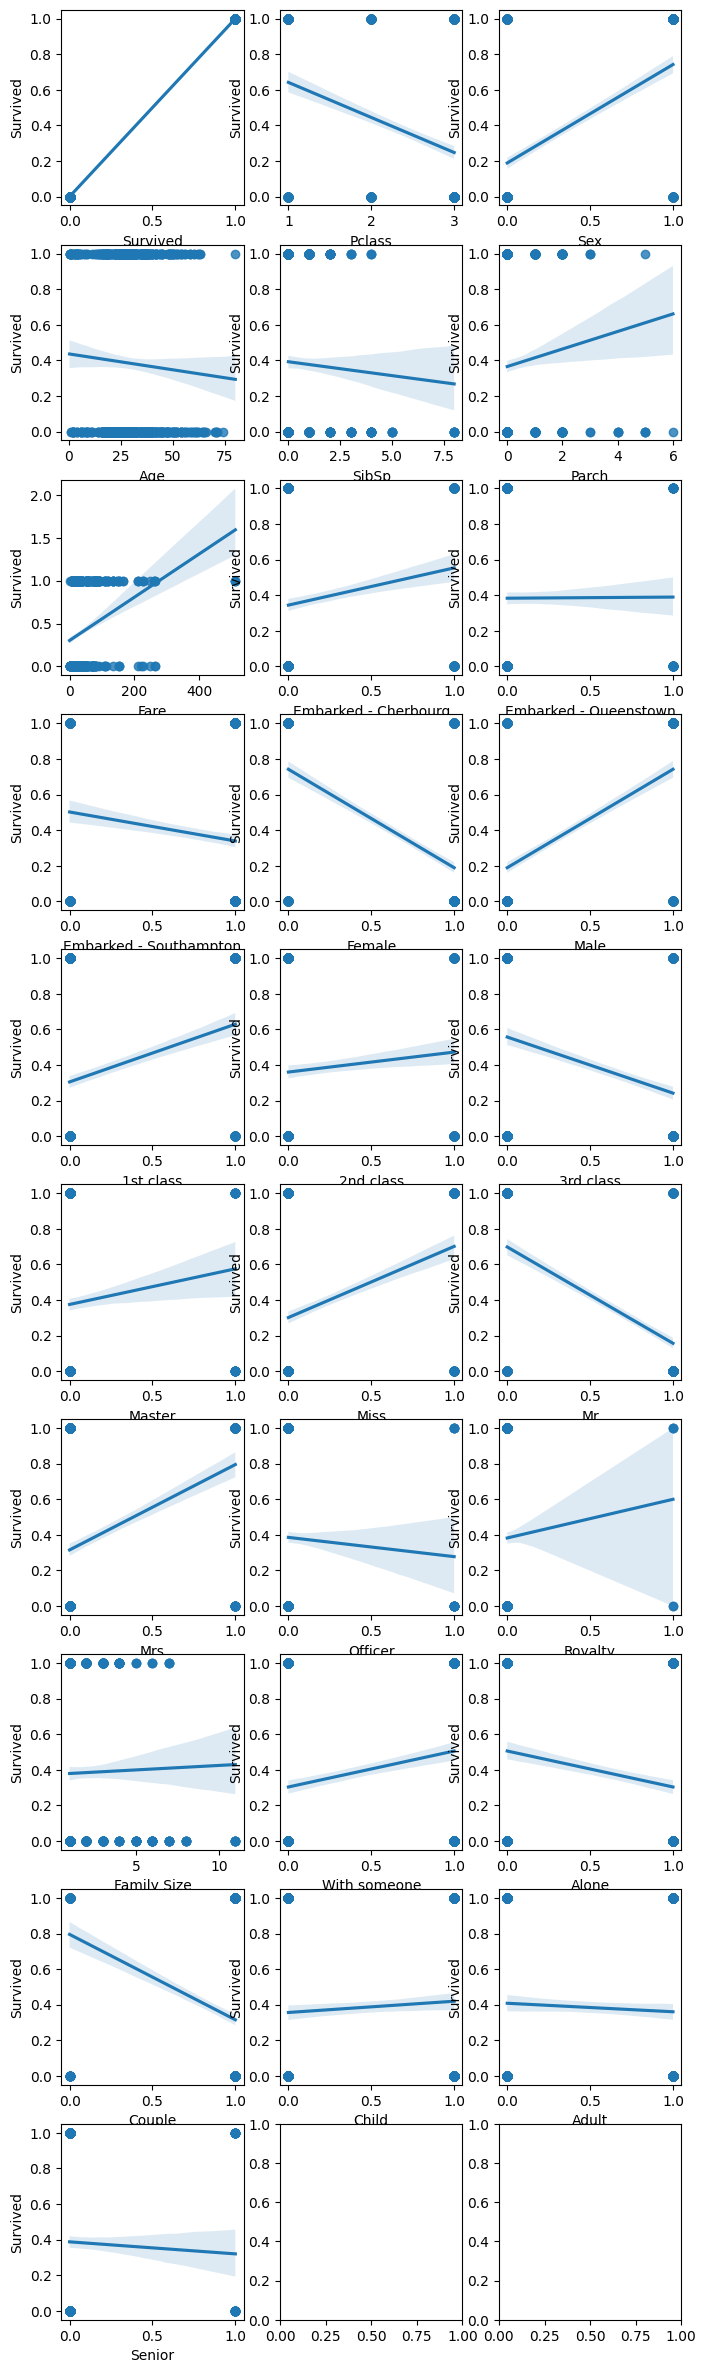

In [109]:
print("Visualise all features vs Survived feature.")
ploters(num_vares, train_data)

In [110]:
#Survival rate
Survived = (sum(train_data['Survived'])/len(train_data['Survived'].index))*100
Survived

38.38383838383838

38% - value of Survived Rate

In [111]:
basic_vars = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
title_vars = train_data[['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty', 'Survived']]
family_alone_vars = train_data[['Family Size', 'With someone', 'Alone', 'Couple', 'Survived']]
socio_economic_status_vars = train_data[['1st class', '2nd class', '3rd class', 'Survived']]
age_grouped_vars = train_data[['Child', 'Adult', 'Senior', 'Survived']]
gender_vars = train_data[['Female', 'Male', 'Survived']]
embarked_vars = train_data[['Embarked - Cherbourg', 'Embarked - Queenstown', 'Embarked - Southampton','Survived']]

In [112]:
print("Correlation matrix - basic vars.")
matrix_corrs = basic_vars.corr()
matrix_corrs

Correlation matrix - basic vars.


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
Pclass,1.000000,-0.131900,-0.398489,0.083081,0.018443,-0.549500,-0.338481
Sex,-0.131900,1.000000,-0.086176,0.114631,0.245489,0.182333,0.543351
Age,-0.398489,-0.086176,1.000000,-0.258137,-0.180334,0.117490,-0.048780
SibSp,0.083081,0.114631,-0.258137,1.000000,0.414838,0.159651,-0.035322
Parch,0.018443,0.245489,-0.180334,0.414838,1.000000,0.216225,0.081629
Fare,-0.549500,0.182333,0.117490,0.159651,0.216225,1.000000,0.257307
Survived,-0.338481,0.543351,-0.048780,-0.035322,0.081629,0.257307,1.000000


Correlation matrix - basic vars.


<Axes: >

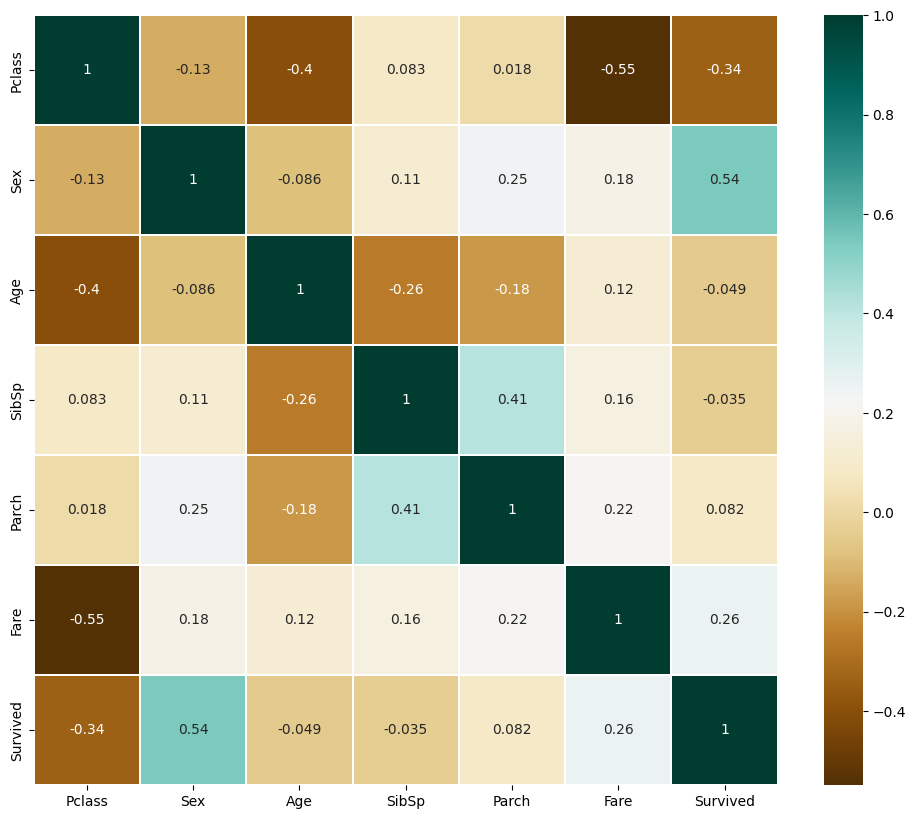

In [113]:
print("Correlation matrix - basic vars.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [114]:
print("Correlation matrix - title vars.")
print("Correlation between numeric values vs Age - train set")
matrix_corrs = title_vars.corr()
matrix_corrs

Correlation matrix - title vars.
Correlation between numeric values vs Age - train set


,Master,Miss,Mr,Mrs,Officer,Royalty,Survived
Master,1.000000,-0.110602,-0.254903,-0.088394,-0.031131,-0.016287,0.085221
Miss,-0.110602,1.000000,-0.599803,-0.207996,-0.073253,-0.038324,0.332795
Mr,-0.254903,-0.599803,1.000000,-0.479363,-0.168826,-0.088324,-0.549199
Mrs,-0.088394,-0.207996,-0.479363,1.000000,-0.058544,-0.030628,0.344935
Officer,-0.031131,-0.073253,-0.168826,-0.058544,1.000000,-0.010787,-0.031316
Royalty,-0.016287,-0.038324,-0.088324,-0.030628,-0.010787,1.000000,0.033391
Survived,0.085221,0.332795,-0.549199,0.344935,-0.031316,0.033391,1.000000


Correlation matrix - title vars.


<Axes: >

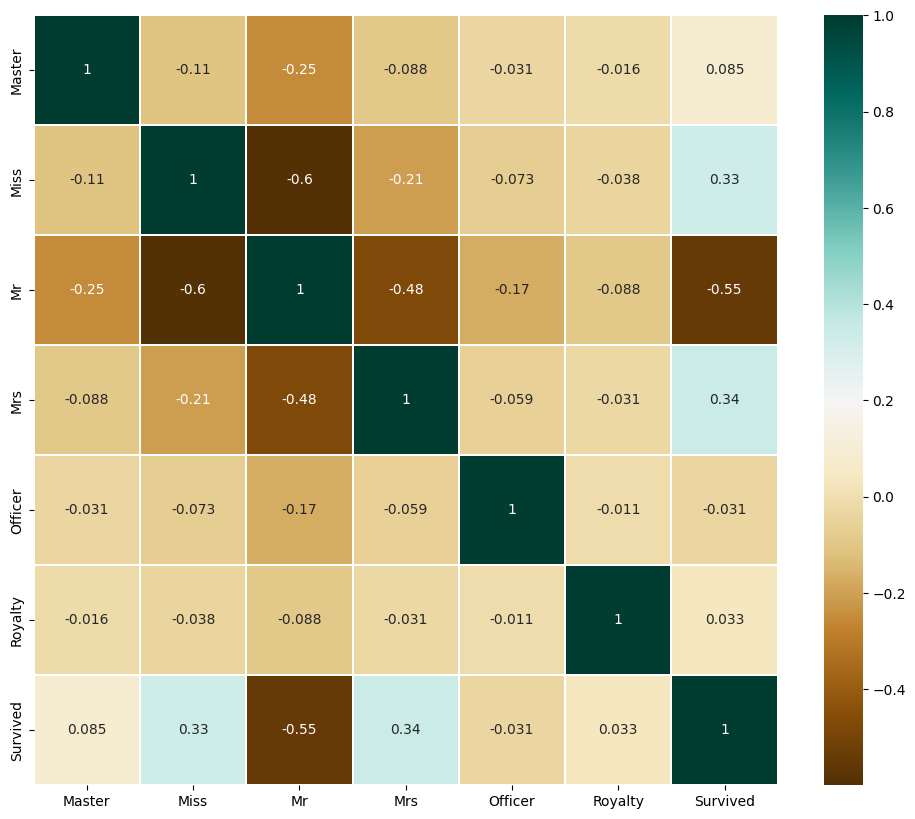

In [115]:
print("Correlation matrix - title vars.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [116]:
print("Correlation matrix - family and alone vars.")
print("Correlation between numeric values vs Age - train set")
matrix_corrs = family_alone_vars.corr()
matrix_corrs

Correlation matrix - family and alone vars.
Correlation between numeric values vs Age - train set


,Family Size,With someone,Alone,Couple,Survived
Family Size,1.000000,0.690922,-0.690922,-0.151534,0.016639
With someone,0.690922,1.000000,-1.000000,-0.357826,0.203367
Alone,-0.690922,-1.000000,1.000000,0.357826,-0.203367
Couple,-0.151534,-0.357826,0.357826,1.000000,-0.344935
Survived,0.016639,0.203367,-0.203367,-0.344935,1.000000


Correlation matrix - family and alone vars.


<Axes: >

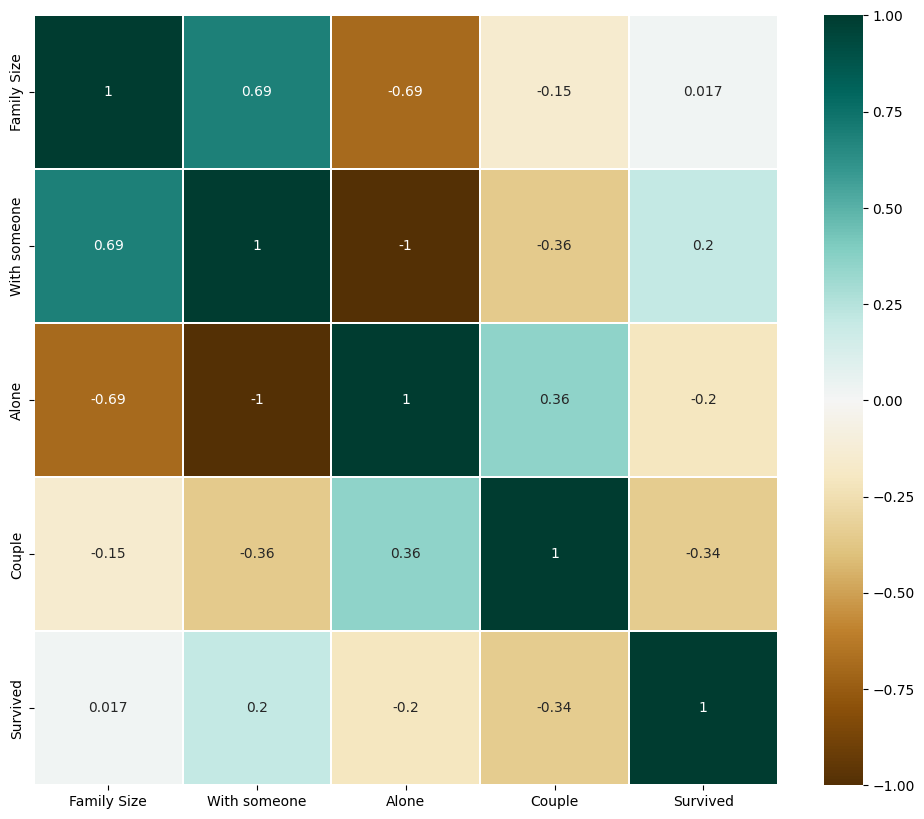

In [117]:
print("Correlation matrix - family and alone vars.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [118]:
print("Correlation matrix - socio-economic status.")
matrix_corrs = socio_economic_status_vars.corr()
matrix_corrs

Correlation matrix - socio-economic status.


,1st class,2nd class,3rd class,Survived
1st class,1.000000,-0.288585,-0.626738,0.285904
2nd class,-0.288585,1.000000,-0.565210,0.093349
3rd class,-0.626738,-0.565210,1.000000,-0.322308
Survived,0.285904,0.093349,-0.322308,1.000000


Correlation matrix - socio-economic status.


<Axes: >

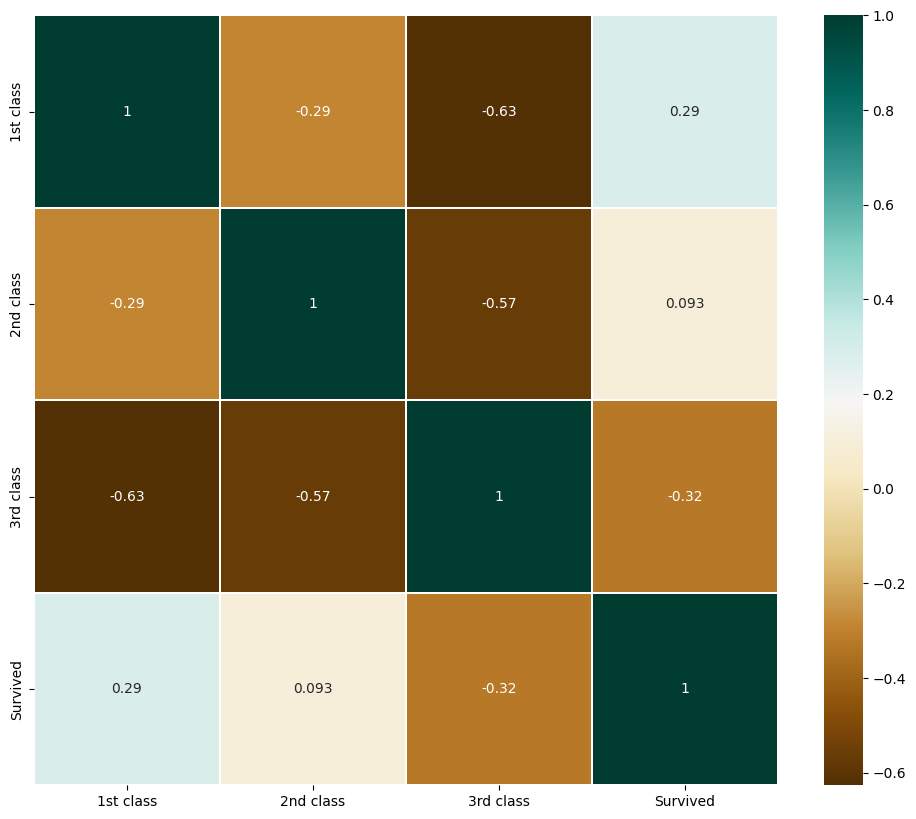

In [119]:
print("Correlation matrix - socio-economic status.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [120]:
print("Correlation matrix - age grouped.")
print("Correlation between numeric values vs Age - train set")
matrix_corrs = age_grouped_vars.corr()
matrix_corrs

Correlation matrix - age grouped.
Correlation between numeric values vs Age - train set


,Child,Adult,Senior,Survived
Child,1.000000,-0.893121,-0.213174,0.064450
Adult,-0.893121,1.000000,-0.249086,-0.049151
Senior,-0.213174,-0.249086,1.000000,-0.032007
Survived,0.064450,-0.049151,-0.032007,1.000000


Correlation matrix - age grouped.


<Axes: >

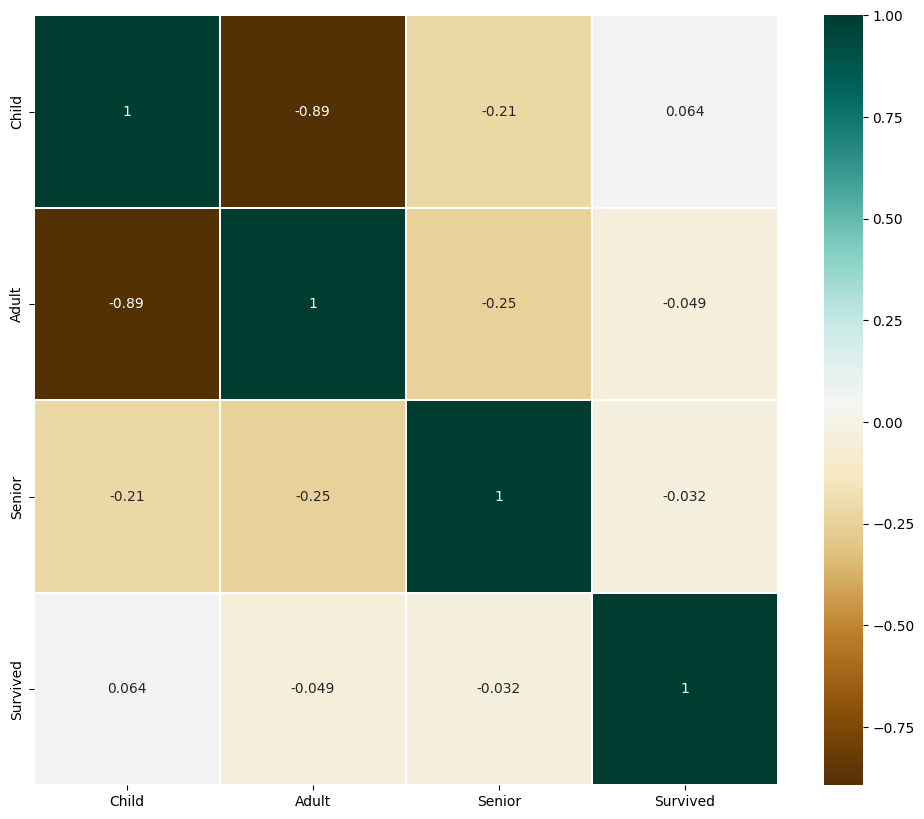

In [121]:
print("Correlation matrix - age grouped.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [122]:
print("Correlation matrix - gender.")
matrix_corrs = gender_vars.corr()
matrix_corrs

Correlation matrix - gender.


,Female,Male,Survived
Female,1.000000,-1.000000,-0.543351
Male,-1.000000,1.000000,0.543351
Survived,-0.543351,0.543351,1.000000


Correlation matrix - gender.


<Axes: >

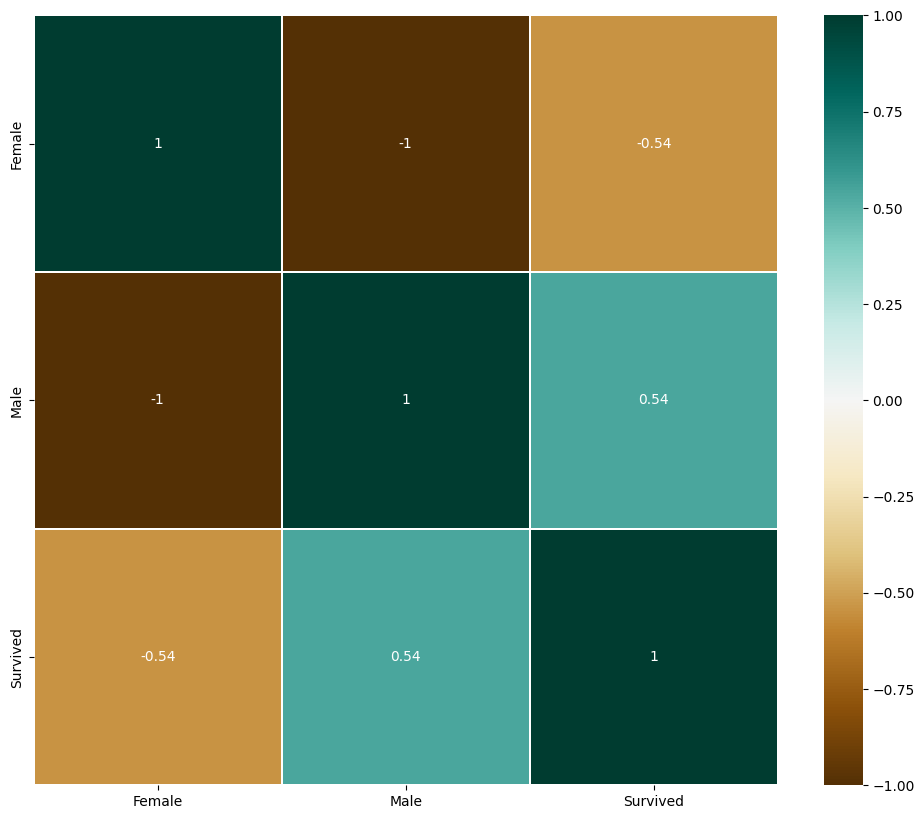

In [123]:
print("Correlation matrix - gender.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [124]:
print("Correlation matrix - embarked.")
matrix_corrs = embarked_vars.corr()
matrix_corrs

Correlation matrix - embarked.


,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,Survived
Embarked - Cherbourg,1.000000,-0.148258,-0.782742,0.168240
Embarked - Queenstown,-0.148258,1.000000,-0.499421,0.003650
Embarked - Southampton,-0.782742,-0.499421,1.000000,-0.149683
Survived,0.168240,0.003650,-0.149683,1.000000


Correlation matrix - embarked.


<Axes: >

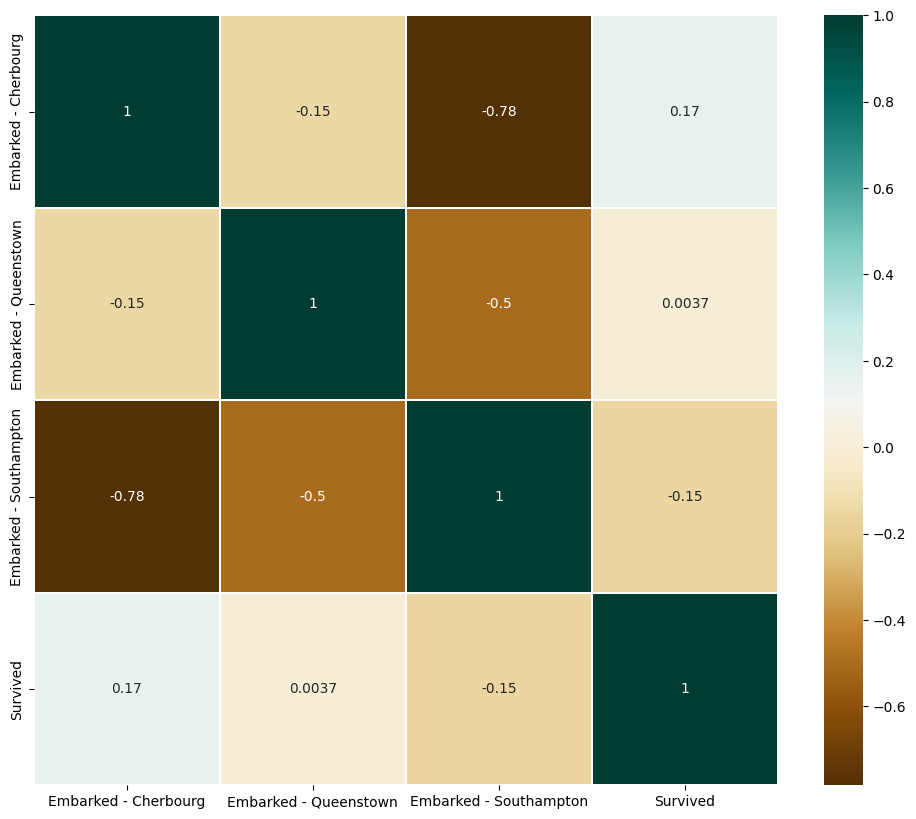

In [125]:
print("Correlation matrix - embarked.")
plt.figure(figsize=(12, 10))
sns.heatmap(data = matrix_corrs,cmap='BrBG', annot=True, linewidths=0.2)

In [126]:
print("Deleting highly correlated features.")
train_data = train_data.drop(columns =['Male', 'With someone'], axis=1)
test_data = test_data.drop(columns =['Male', 'With someone'], axis=1)
train_data.head()

Deleting highly correlated features.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked - Cherbourg,Embarked - Queenstown,Embarked - Southampton,...,Mr,Mrs,Officer,Royalty,Family Size,Alone,Couple,Child,Adult,Senior
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,2,0.0,1.0,0.0,1.0,0.0
1,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,0.0,1.0,0.0
3,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1,1.0,1.0,1.0,0.0,0.0


I deleted highly correlated columns/features which values of correlation coefficient was higher than 0,95. 

In [127]:
original_train_set_without_survived = train_data.drop("Survived", axis=1)
original_train_set_with_only_survived = train_data["Survived"]

In [128]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    original_train_set_without_survived, original_train_set_with_only_survived, train_size=0.6, test_size=0.4, random_state=0)
print(X_train_selected.shape, y_train_selected.shape)
print(X_test_selected.shape, y_test_selected.shape)

(534, 25) (534,)
(357, 25) (357,)


In [129]:
print("Standard Scaler.")
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_selected = sc.fit_transform(X_train_selected)

X_test_selected = sc.transform(X_test_selected)

Test = sc.transform(test_data)

Standard Scaler.


In [130]:
print('Modeling and ROC, AUC, accuracy scores.\n')

print("Decision Tree Classifier")

TitanicTree_selected = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
TitanicTree_selected

Modeling and ROC, AUC, accuracy scores.

Decision Tree Classifier


DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [131]:
TitanicTree_selected.fit(X_train_selected,y_train_selected)
predTitanicTree_selected = TitanicTree_selected.predict(X_test_selected)

print (predTitanicTree_selected[0:5])
print (y_test_selected [0:5])

[0 0 0 1 1]
495    0
648    0
278    0
31     1
255    1
Name: Survived, dtype: int64


In [132]:
print("Decisions tree hyperparameters tuning by Grid Search.")
params = {'criterion':['gini','entropy'],
          'max_depth': [3, 5, 7],
          'min_samples_split': [2, 4, 8],
          'max_leaf_nodes': [3, 8, 12, 18, 22, 26]}

grid_object_1 = GridSearchCV(DecisionTreeClassifier(), params, cv=3, n_jobs=3)

grid_object_1.fit(X_train_selected,y_train_selected)


# show best parameter for classifier
Dec_tree_params = grid_object_1.best_params_
Dec_tree_params 

Decisions tree hyperparameters tuning by Grid Search.


{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 8,
 'min_samples_split': 2}

In [133]:
Dec_tree_est = grid_object_1.best_estimator_
Dec_tree_est

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8)

In [134]:
print("Train model with better hyperparameters.")
TitanicTree_tuning = DecisionTreeClassifier(criterion='gini', max_depth = 5, max_leaf_nodes = 8, min_samples_split = 4)
TitanicTree_tuning

Train model with better hyperparameters.


DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8, min_samples_split=4)

In [135]:
TitanicTree_tuning.fit(X_train_selected,y_train_selected)
predTitanicTree_tuning = TitanicTree_tuning.predict(X_test_selected)

print (predTitanicTree_tuning [0:5])
print (y_test_selected [0:5])

[0 0 0 1 1]
495    0
648    0
278    0
31     1
255    1
Name: Survived, dtype: int64


In [136]:
accuracy_validation_calcs(y_test_selected, predTitanicTree_tuning, X_train_selected, y_train_selected, TitanicTree_tuning)

Train set Accuracy:  0.8539325842696629
Test set Accuracy:  0.803921568627451
Confusion matrix:  [[190  31]
 [ 39  97]]
Precision score:  0.7578125
Recall score:  0.7132352941176471


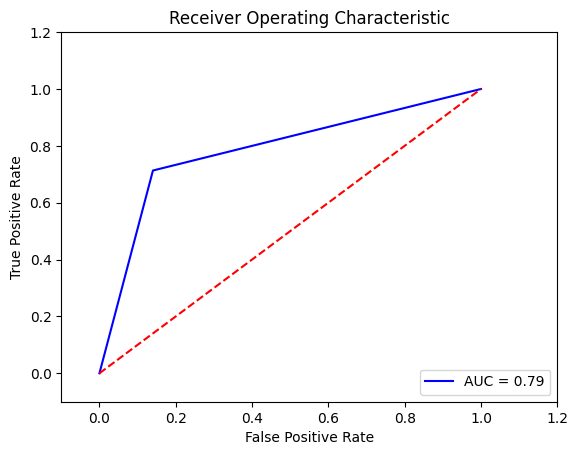

In [137]:
ROC_AUC_calc(y_test_selected,predTitanicTree_tuning)

In [138]:
decision_tree_cross = cross_val_score_model(TitanicTree_tuning, original_train_set_without_survived, original_train_set_with_only_survived)
decision_tree_cross

0.8226716604244693

In [139]:
# RFC Parameters tunning 

rf_class = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}


rfc_grid = GridSearchCV(rf_class,param_grid = rf_param_grid, cv=3, scoring="accuracy", n_jobs= 3, verbose = 1)

rfc_grid.fit(X_train_selected,y_train_selected)

rfc_best = rfc_grid.best_estimator_

# Best score
print(rfc_grid.best_score_)
Rand_For_params = rfc_grid.best_params_
Rand_For_params

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0.8239700374531834


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [140]:
random_forest_classifier_100 = RandomForestClassifier(bootstrap=False, n_estimators=100, random_state=0, criterion='gini', max_depth=None, min_samples_split=10, max_features=10, min_samples_leaf=10)

random_forest_classifier_100.fit(X_train_selected, y_train_selected)

y_pred_100 = random_forest_classifier_100.predict(X_test_selected)

In [141]:
accuracy_validation_calcs(y_test_selected, y_pred_100, X_train_selected, y_train_selected, random_forest_classifier_100)

Train set Accuracy:  0.8614232209737828
Test set Accuracy:  0.8207282913165266
Confusion matrix:  [[198  23]
 [ 41  95]]
Precision score:  0.8050847457627118
Recall score:  0.6985294117647058


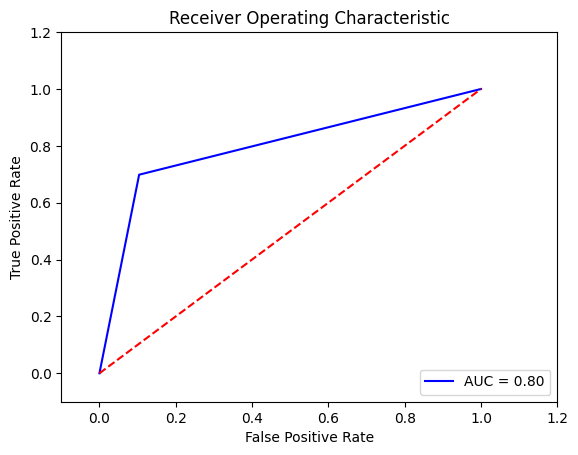

In [142]:
ROC_AUC_calc(y_test_selected,y_pred_100)

In [143]:
random_forest_cross = cross_val_score_model(random_forest_classifier_100, original_train_set_without_survived, original_train_set_with_only_survived)
random_forest_cross

0.8384394506866417

In [144]:
print("K nearest neighbor (KNN)")

 
neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train_selected,y_train_selected)
neigh

K nearest neighbor (KNN)


KNeighborsClassifier(n_neighbors=9)

In [145]:
param_neighbors = {
    'n_neighbors': [3, 5, 10, 12, 16],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 80]}

grid_object0 = GridSearchCV(KNeighborsClassifier(), param_neighbors, cv=3, n_jobs=3, scoring='accuracy')
grid_object0.fit(X_train_selected,y_train_selected)


# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_object0.best_params_)
print("Best score: ", grid_object0.best_score_)



Best set of hyperparameters:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3}
Best score:  0.8258426966292135


In [146]:
print('Testing models accuracy on all features.\n')

print("K nearest neighbor (KNN)")

neigh = KNeighborsClassifier(n_neighbors = 3, leaf_size=30, algorithm = 'ball_tree').fit(X_train_selected,y_train_selected)
neigh

Testing models accuracy on all features.

K nearest neighbor (KNN)


KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3)

In [147]:
y_hat_1 = neigh.predict(X_test_selected)
y_hat_1 [0:5]

array([0, 0, 0, 1, 0])

In [148]:
accuracy_validation_calcs(y_test_selected, y_hat_1, X_train_selected, y_train_selected, neigh)

Train set Accuracy:  0.8838951310861424
Test set Accuracy:  0.8095238095238095
Confusion matrix:  [[194  27]
 [ 41  95]]
Precision score:  0.7786885245901639
Recall score:  0.6985294117647058


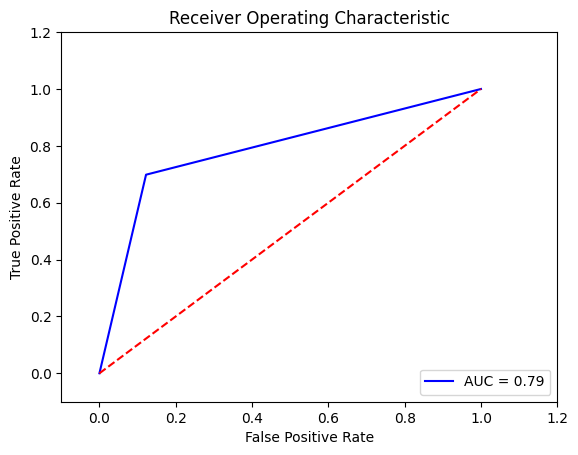

In [149]:
ROC_AUC_calc(y_test_selected,y_hat_1)

In [150]:
cross_val_score_model(neigh, original_train_set_without_survived, original_train_set_with_only_survived)

0.7273158551810237

In [151]:
from sklearn.model_selection import GridSearchCV
grid_params = { 'n_neighbors' : [2,4,5,8,10,12,14,16, 20,22],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=4, n_jobs = -1)
g_res = gs.fit(X_train_selected, y_train_selected)
g_res.best_score_

Fitting 4 folds for each of 60 candidates, totalling 240 fits


0.8315144203793065

In [152]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

In [153]:
Neigh_est = g_res.best_estimator_
Neigh_est

KNeighborsClassifier(metric='manhattan')

In [154]:
print("K nearest neighbor (KNN)")

neigh_tuned = KNeighborsClassifier(n_neighbors = 5, metric = 'manhattan', weights = 'uniform').fit(X_train_selected,y_train_selected)
neigh_tuned

K nearest neighbor (KNN)


KNeighborsClassifier(metric='manhattan')

In [155]:
y_hat_knn_tuned = neigh_tuned.predict(X_test_selected)
y_hat_knn_tuned [0:5]

array([0, 0, 0, 1, 0])

In [156]:
accuracy_validation_calcs(y_test_selected, y_hat_knn_tuned, X_train_selected, y_train_selected, neigh_tuned)

Train set Accuracy:  0.8764044943820225
Test set Accuracy:  0.8067226890756303
Confusion matrix:  [[194  27]
 [ 42  94]]
Precision score:  0.7768595041322314
Recall score:  0.6911764705882353


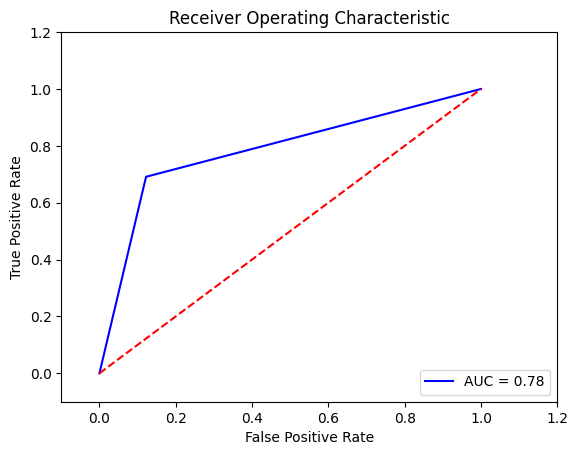

In [157]:
ROC_AUC_calc(y_test_selected,y_hat_knn_tuned)

In [158]:
neigh_cross = cross_val_score_model(neigh_tuned, original_train_set_without_survived, original_train_set_with_only_survived)
neigh_cross

0.7756429463171036

In [159]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_selected,y_train_selected)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [160]:
yhat_log = LR.predict(X_test_selected)
yhat_log [0:5]

array([0, 0, 0, 1, 1])

In [161]:
yhat_prob_selected = LR.predict_proba(X_test_selected)
yhat_prob_selected [0:5]

array([[0.76134301, 0.23865699],
       [0.82416245, 0.17583755],
       [0.63168911, 0.36831089],
       [0.06819767, 0.93180233],
       [0.21798027, 0.78201973]])

In [162]:
jaccard_score(y_test_selected, yhat_log,pos_label=0)

0.7181467181467182

In [163]:
accuracy_validation_calcs(y_test_selected, yhat_log, X_train_selected, y_train_selected, LR)

Train set Accuracy:  0.8183520599250936
Test set Accuracy:  0.7955182072829131
Confusion matrix:  [[186  35]
 [ 38  98]]
Precision score:  0.7368421052631579
Recall score:  0.7205882352941176


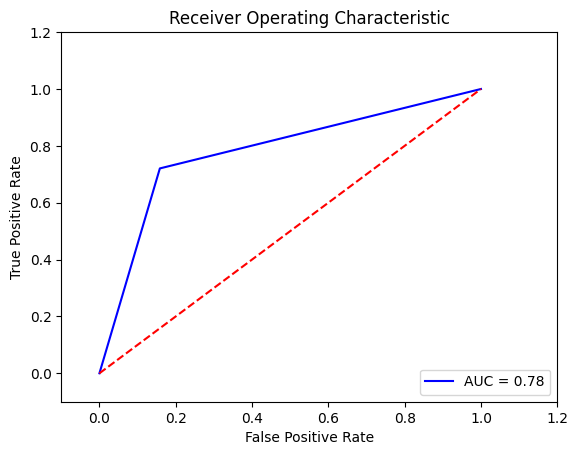

In [164]:
ROC_AUC_calc(y_test_selected,yhat_log)

In [165]:
lr_cross = cross_val_score_model(LR, original_train_set_without_survived, original_train_set_with_only_survived)
lr_cross

0.78458177278402

In [166]:
print("SVM (Support Vector Machines)")

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_selected, y_train_selected) 

SVM (Support Vector Machines)


SVC()

In [167]:
yhat_selected_SVC = clf.predict(X_test_selected)
yhat_selected_SVC [0:5]

array([0, 0, 0, 1, 1])

In [168]:
accuracy_validation_calcs(y_test_selected, yhat_selected_SVC, X_train_selected, y_train_selected, clf)

Train set Accuracy:  0.8595505617977528
Test set Accuracy:  0.8179271708683473
Confusion matrix:  [[198  23]
 [ 42  94]]
Precision score:  0.8034188034188035
Recall score:  0.6911764705882353


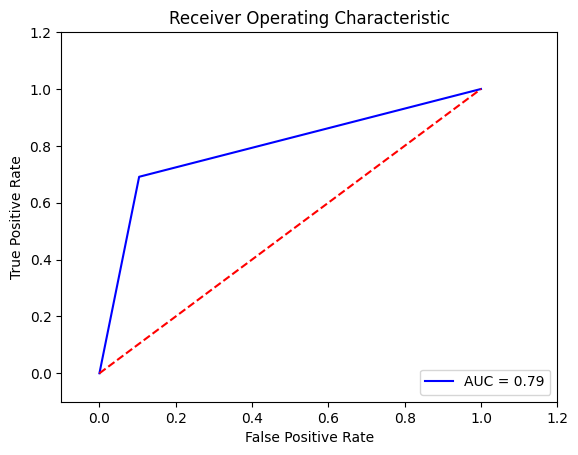

In [169]:
ROC_AUC_calc(y_test_selected,yhat_selected_SVC)

In [170]:
SVC_cross = cross_val_score_model(clf, original_train_set_without_survived, original_train_set_with_only_survived)
SVC_cross

0.6891885143570537

In [171]:
param_SVC = {
    'C': [0.1, 50, 70],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']}

grid_object_SVC = GridSearchCV(svm.SVC(), param_SVC, cv=3, n_jobs=3, scoring='accuracy')
grid_object_SVC.fit(X_train_selected,y_train_selected)


# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_object_SVC.best_params_)
print("Best score: ", grid_object_SVC.best_score_)



Best set of hyperparameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.8146067415730337


In [172]:
SVC_best_est = grid_object_SVC.best_estimator_
print(SVC_best_est)

SVC(C=0.1)


In [173]:
print("SVM (Support Vector Machines)")

clf_tuned = svm.SVC(C=0.1, gamma='scale', kernel='rbf')
clf_tuned.fit(X_train_selected, y_train_selected) 

SVM (Support Vector Machines)


SVC(C=0.1)

In [174]:
yhat_tuned = clf_tuned.predict(X_test_selected)
yhat_tuned [0:5]

array([0, 0, 0, 1, 1])

In [175]:
accuracy_validation_calcs(y_test_selected, yhat_tuned, X_train_selected, y_train_selected, clf_tuned)

Train set Accuracy:  0.8389513108614233
Test set Accuracy:  0.7983193277310925
Confusion matrix:  [[191  30]
 [ 42  94]]
Precision score:  0.7580645161290323
Recall score:  0.6911764705882353


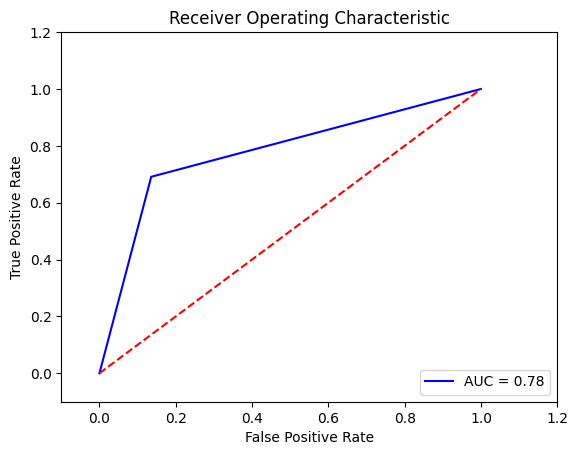

In [176]:
ROC_AUC_calc(y_test_selected,yhat_tuned)

In [177]:
cross_val_score_model(clf_tuned, original_train_set_without_survived, original_train_set_with_only_survived)

0.6768414481897629

In [178]:
rf = RandomForestClassifier(n_estimators=400, max_depth=None, max_leaf_nodes=None, random_state=None, class_weight=None, warm_start=False, oob_score=False, verbose = 0, min_samples_leaf=1, min_samples_split = 2)
rf.fit(X_train_selected, y_train_selected)
rf_prediction = rf.predict(X_test_selected)

score = metrics.accuracy_score(y_test_selected, rf_prediction)
print(score)

0.8067226890756303


In [179]:
param_Rand_For = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0,1],
    'min_weight_fraction_leaf': [0.0,0.5],
    'n_estimators' : [10,50, 100, 300],
    'max_depth' : [1, 10],
     'min_samples_split':[2,6]
}
    
    
grid_object_rand = GridSearchCV(RandomForestClassifier(), param_Rand_For, cv=3, n_jobs=3, error_score = 'raise')
grid_object_rand.fit(X_train_selected,y_train_selected)


# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_object_rand.best_params_)
print("Best score: ", grid_object_rand.best_score_)



Best set of hyperparameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10}
Best score:  0.8202247191011236


I create another version to assess deeper problems with hyperparameters.

In [180]:
rf_tuned = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf_tuned.fit(X_train_selected, y_train_selected)
rf_tuned_prediction = rf_tuned.predict(X_test_selected)

In [181]:
accuracy_validation_calcs(y_test_selected, rf_tuned_prediction, X_train_selected, y_train_selected, rf_tuned)

Train set Accuracy:  0.8932584269662921
Test set Accuracy:  0.8207282913165266
Confusion matrix:  [[195  26]
 [ 38  98]]
Precision score:  0.7903225806451613
Recall score:  0.7205882352941176


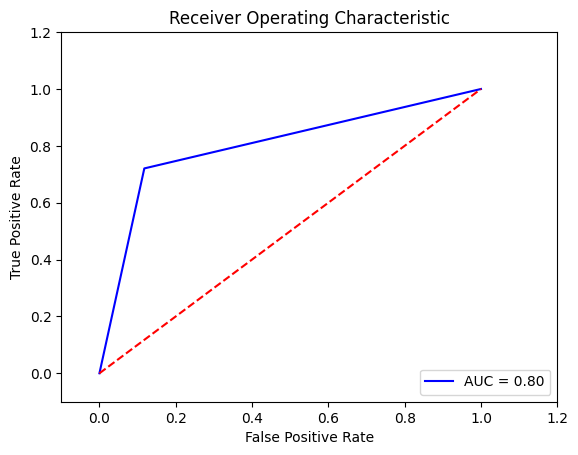

In [182]:
ROC_AUC_calc(y_test_selected,rf_tuned_prediction)

In [183]:
random_forest_tuned_cross = cross_val_score_model(rf_tuned, original_train_set_without_survived, original_train_set_with_only_survived)
random_forest_tuned_cross

0.8249687890137329

In [184]:
print("Extra Tree Classifier.")
#X, y = make_classification(n_features=4, random_state=0)
clf_extra = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_extra.fit(X_train_selected, y_train_selected)
ExtraTreesClassifier(random_state=0)
clf_extra.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0]])
#array([1])

pred_clf_extra = clf_extra.predict(X_test_selected)

print (pred_clf_extra [0:5])
print (y_test_selected [0:5])

Extra Tree Classifier.
[1 0 0 1 0]
495    0
648    0
278    0
31     1
255    1
Name: Survived, dtype: int64


In [185]:
accuracy_validation_calcs(y_test_selected, pred_clf_extra, X_train_selected, y_train_selected, clf_extra)

Train set Accuracy:  0.9850187265917603
Test set Accuracy:  0.7815126050420168
Confusion matrix:  [[185  36]
 [ 42  94]]
Precision score:  0.7230769230769231
Recall score:  0.6911764705882353


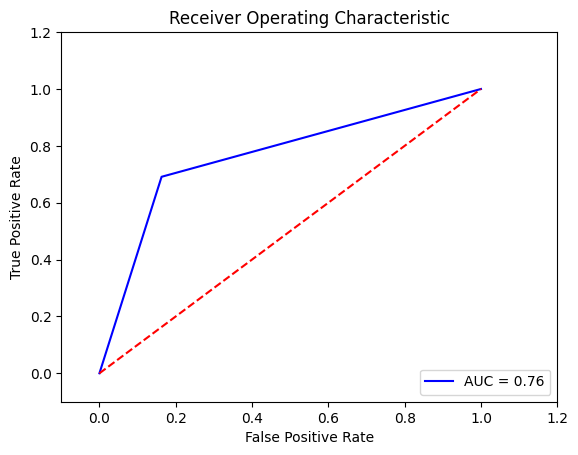

In [186]:
ROC_AUC_calc(y_test_selected,pred_clf_extra)

In [187]:
cross_val_score_model(clf_extra, original_train_set_without_survived, original_train_set_with_only_survived)


0.7924594257178528

In [188]:
print("Decisions tree hyperparameters tuning by Grid Search.")
params = {'criterion':['gini','entropy'],
          'max_depth': [3, 5, 7],
          'min_samples_split': [2, 4, 8],
          'max_leaf_nodes': [3, 8, 12, 18, 22, 26],
          'n_estimators' : [20, 200, 400]}

grid_object2 = GridSearchCV(ExtraTreesClassifier(), params, cv=3, n_jobs=3)

grid_object2.fit(X_train_selected,y_train_selected)
Extra_params1 = grid_object2.best_params_
Extra_params1

Decisions tree hyperparameters tuning by Grid Search.


{'criterion': 'gini',
 'max_depth': 7,
 'max_leaf_nodes': 26,
 'min_samples_split': 4,
 'n_estimators': 20}

In [189]:
Extra_est = grid_object2.best_estimator_
Extra_est

ExtraTreesClassifier(max_depth=7, max_leaf_nodes=26, min_samples_split=4,
                     n_estimators=20)

In [190]:
print("Extra Tree Classifier tuned hyperparameters.")
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
#X, y = make_classification(n_features=4, random_state=0)
clf_extra_tuned = ExtraTreesClassifier(n_estimators=20, criterion='gini', random_state=0,max_depth=5,max_leaf_nodes=30,min_samples_split= 8)
clf_extra_tuned.fit(X_train_selected, y_train_selected)
ExtraTreesClassifier(random_state=0)
clf_extra_tuned.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0]])
#array([1])

pred_clf_extra_tuned = clf_extra_tuned.predict(X_test_selected)

print (pred_clf_extra_tuned [0:5])
print (y_test_selected [0:5])

Extra Tree Classifier tuned hyperparameters.
[0 0 0 1 1]
495    0
648    0
278    0
31     1
255    1
Name: Survived, dtype: int64


In [191]:
accuracy_validation_calcs(y_test_selected, pred_clf_extra_tuned, X_train_selected, y_train_selected, clf_extra_tuned)

Train set Accuracy:  0.8539325842696629
Test set Accuracy:  0.8067226890756303
Confusion matrix:  [[197  24]
 [ 45  91]]
Precision score:  0.7913043478260869
Recall score:  0.6691176470588235


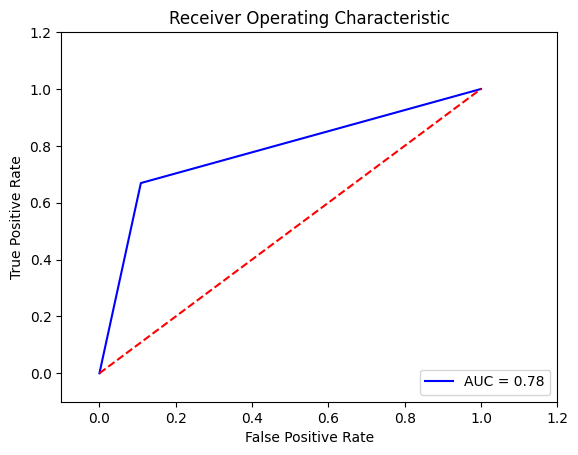

In [192]:
ROC_AUC_calc(y_test_selected,pred_clf_extra_tuned)

In [193]:
extra_tree_cross = cross_val_score_model(clf_extra_tuned, original_train_set_without_survived, original_train_set_with_only_survived)
extra_tree_cross

0.8316479400749064

In [194]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=30,
            learning_rate=0.4, random_state=42)
ada_boost.fit(X_train_selected, y_train_selected)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=30, random_state=42)

In [195]:
y_pred_final_ada = ada_boost.predict(X_test_selected)

In [196]:
accuracy_validation_calcs(y_test_selected, y_pred_final_ada, X_train_selected, y_train_selected, ada_boost)

Train set Accuracy:  0.8445692883895131
Test set Accuracy:  0.8207282913165266
Confusion matrix:  [[192  29]
 [ 35 101]]
Precision score:  0.7769230769230769
Recall score:  0.7426470588235294


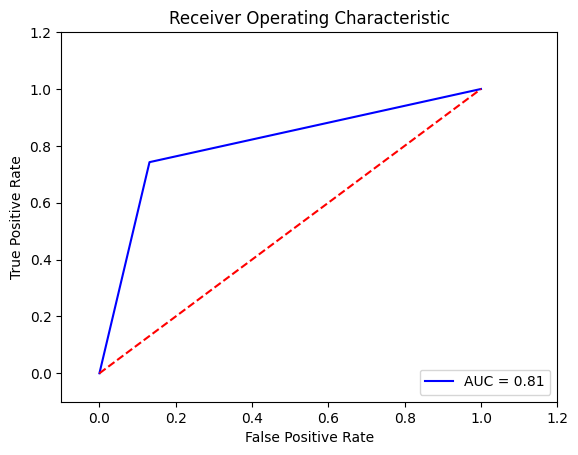

In [197]:
ROC_AUC_calc(y_test_selected,y_pred_final_ada)

In [198]:
cross_val_score_model(ada_boost, original_train_set_without_survived, original_train_set_with_only_survived)

0.8215605493133584

In [199]:
print("Decisions tree hyperparameters tuning by Grid Search.")
params_ada = {'random_state': [10, 42, None],
          'learning_rate': [0.1, 0.5, 1.0],
          'n_estimators' : [20, 100, 300]}

grid_ada_b = GridSearchCV(AdaBoostClassifier(), params_ada, cv=3, n_jobs=3)


grid_ada_b.fit(X_train_selected,y_train_selected)

Adab_params = grid_ada_b.best_params_
Adab_params

Decisions tree hyperparameters tuning by Grid Search.


{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 10}

In [200]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_tuned = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=100,
            learning_rate=0.1, random_state=10)
ada_boost_tuned.fit(X_train_selected, y_train_selected)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=100, random_state=10)

In [201]:
y_pred_tuned_ada = ada_boost_tuned.predict(X_test_selected)

In [202]:
accuracy_validation_calcs(y_test_selected, y_pred_tuned_ada, X_train_selected, y_train_selected, ada_boost_tuned)

Train set Accuracy:  0.8408239700374532
Test set Accuracy:  0.8235294117647058
Confusion matrix:  [[195  26]
 [ 37  99]]
Precision score:  0.792
Recall score:  0.7279411764705882


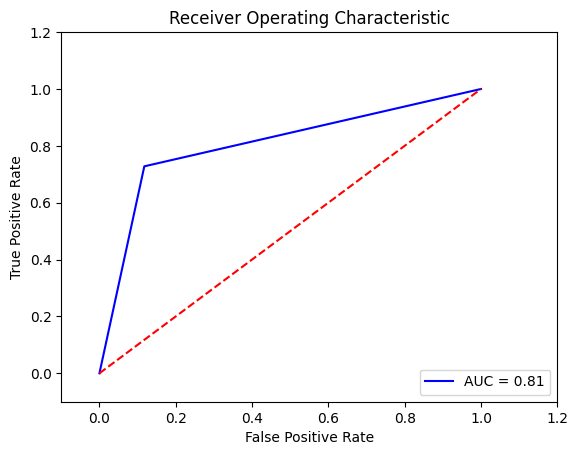

In [203]:
ROC_AUC_calc(y_test_selected,y_pred_tuned_ada)

In [204]:
adab_cross = cross_val_score_model(ada_boost_tuned, original_train_set_without_survived, original_train_set_with_only_survived)
adab_cross

0.8260424469413232

In [205]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf=GradientBoostingClassifier(n_estimators=20,learning_rate=0.9,max_depth=2,max_features=2,random_state=5)
gb_clf.fit(X_train_selected,y_train_selected)
y_pred_gb=gb_clf.predict(X_test_selected)
accuracy_score(y_pred_gb,y_test_selected)

0.8011204481792717

In [206]:
accuracy_validation_calcs(y_test_selected, y_pred_gb, X_train_selected, y_train_selected, gb_clf)

Train set Accuracy:  0.8689138576779026
Test set Accuracy:  0.8011204481792717
Confusion matrix:  [[191  30]
 [ 41  95]]
Precision score:  0.76
Recall score:  0.6985294117647058


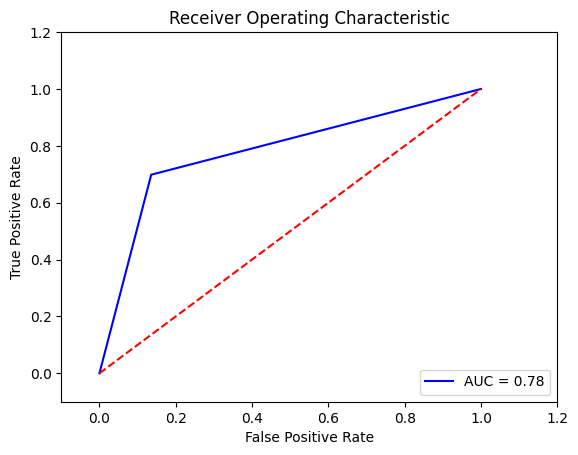

In [207]:
ROC_AUC_calc(y_test_selected,y_pred_gb)

In [208]:
gradientb_cross = cross_val_score_model(gb_clf, original_train_set_without_survived, original_train_set_with_only_survived)
gradientb_cross

0.8238077403245943

In [209]:
print("Decisions tree hyperparameters tuning by Grid Search.")
params_gradient = {'loss': ['log_loss', 'exponential'],
          'learning_rate': [0.1, 0.5, 1.0],
          'n_estimators' : [20, 100, 300],
          'random_state': [10, 42, None],
          'subsample': [0.1, 1.0],
          'criterion' : ['friedman_mse','squared_error']}

gradient_grid = GridSearchCV(GradientBoostingClassifier(), params_gradient, cv=3, n_jobs=3)


gradient_grid.fit(X_train_selected,y_train_selected)

 #'max_depth':np.arange(1,21).tolist()[0::2],
          #'min_samples_split':np.arange(2,11).tolist()[0::2],
           #   'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

# show best parameter for classifier
gradient_grid_params = gradient_grid.best_params_
gradient_grid_params

Decisions tree hyperparameters tuning by Grid Search.


{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'n_estimators': 20,
 'random_state': 10,
 'subsample': 1.0}

In [210]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_clf=GradientBoostingClassifier(n_estimators=20,learning_rate=0.1,random_state=10, criterion='friedman_mse', loss='exponential', subsample = 1.0)
gradient_clf.fit(X_train_selected,y_train_selected)
y_pred_gradient=gradient_clf.predict(X_test_selected)
accuracy_score(y_pred_gradient,y_test_selected)

0.8151260504201681

In [211]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_clf=GradientBoostingClassifier(n_estimators=20,learning_rate=0.1,random_state=10, criterion='friedman_mse', loss='log_loss', subsample = 1.0)
gradient_clf.fit(X_train_selected,y_train_selected)
y_pred_gradient=gradient_clf.predict(X_test_selected)
accuracy_score(y_pred_gradient,y_test_selected)

0.8235294117647058

In [212]:
accuracy_validation_calcs(y_test_selected, y_pred_gradient, X_train_selected, y_train_selected, gradient_clf)

Train set Accuracy:  0.8595505617977528
Test set Accuracy:  0.8235294117647058
Confusion matrix:  [[198  23]
 [ 40  96]]
Precision score:  0.8067226890756303
Recall score:  0.7058823529411765


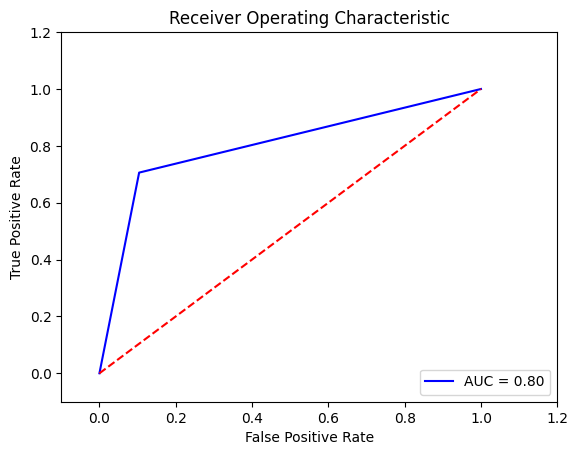

In [213]:
ROC_AUC_calc(y_test_selected,y_pred_gradient)

In [214]:
gradientb_tuned_cross = cross_val_score_model(gradient_clf, original_train_set_without_survived, original_train_set_with_only_survived)
gradientb_tuned_cross

0.8260424469413234

In [215]:
x = original_train_set_without_survived
y = original_train_set_with_only_survived

In [216]:
print("Accuracy score for selected models.")
ML_models = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'KNN', 
              'Logistic Regression', 'SVC', 'Random Forest Tuned', 
              'Extra Trees Classifier', 'Ada Boost Classifier', 
              'Gradient Boost Classifier', 'Gradient Boost Classifier Tuned'],
    'Score': [decision_tree_cross, random_forest_cross, neigh_cross, 
              lr_cross, SVC_cross, random_forest_tuned_cross, 
              extra_tree_cross, adab_cross, gradientb_cross,gradientb_tuned_cross]})
ML_models.sort_values(by='Score',ascending=False)

Accuracy score for selected models.


,Model,Score
1,Random Forest,0.838439
6,Extra Trees Classifier,0.831648
9,Gradient Boost Classifier Tuned,0.826042
7,Ada Boost Classifier,0.826042
5,Random Forest Tuned,0.824969
8,Gradient Boost Classifier,0.823808
0,Decision Tree,0.822672
3,Logistic Regression,0.784582
2,KNN,0.775643
4,SVC,0.689189


"The best model accuracy (based on train is Random Forest).
Hovewer train and test accuracy suggest that may be some problem with overfitting.
I will check it on visualisations.

Train set Accuracy:  0.8614232209737828
Test set Accuracy:  0.8207282913165266
Confusion matrix:  [[198  23]
 [ 41  95]]
Precision score:  0.8050847457627118
Recall score:  0.6985294117647058

Analyze Overfitting and Underfitting.


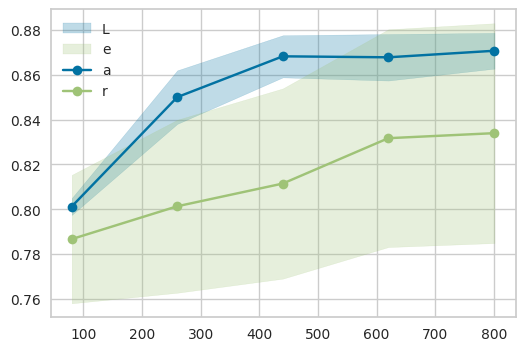

In [217]:
print("Analyze Overfitting and Underfitting.")
from yellowbrick.model_selection import (LearningCurve)
fig, ax = plt.subplots(figsize=(6,4))
lc = LearningCurve(RandomForestClassifier(bootstrap=False, n_estimators=100, random_state=0, criterion='gini', max_depth=None, min_samples_split=10, max_features=10, min_samples_leaf=10),
                  cv=10)
lc.fit(x,y)
ax.legend("Learning Curve for Random Forest Model.")

Validation Curve for Random Forest - max depth inspect.


[Text(0.5, 0, 'max_depth'), Text(0, 0.5, 'score')]

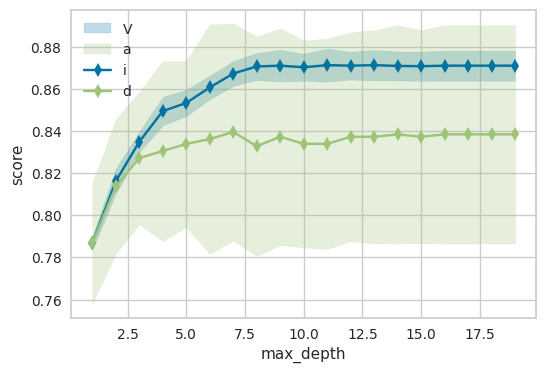

In [218]:
print("Validation Curve for Random Forest - max depth inspect.")
from yellowbrick.model_selection import (ValidationCurve)
fig, ax = plt.subplots(figsize=(6,4))
vc = ValidationCurve(RandomForestClassifier(bootstrap=False, n_estimators=100, random_state=0, criterion='gini', max_depth=None, min_samples_split=10, max_features=10, min_samples_leaf=10),
                  param_name = 'max_depth', param_range =np.arange(1,20),cv=10, n_jobs= -1)
vc.fit(x,y)
ax.legend("Vaidation Curve for Random Forest Model - max depth influence.")
vc.ax.set(
xlabel='max_depth', ylabel='score')

Overfitting and Underfitting.


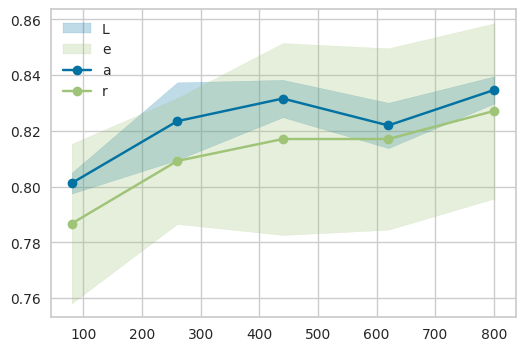

In [219]:
print("Overfitting and Underfitting.")
from yellowbrick.model_selection import (LearningCurve)
fig, ax = plt.subplots(figsize=(6,4))
lc = LearningCurve(RandomForestClassifier(bootstrap=False, n_estimators=100, random_state=0, criterion='gini', max_depth=3, min_samples_split=10, max_features=10, min_samples_leaf=10),
                  cv=10)
lc.fit(x,y)
ax.legend("Learning Curve for Random Forest Model.")

I change the max_depth to 3 and it improve fitting.

Overfitting and Underfitting.


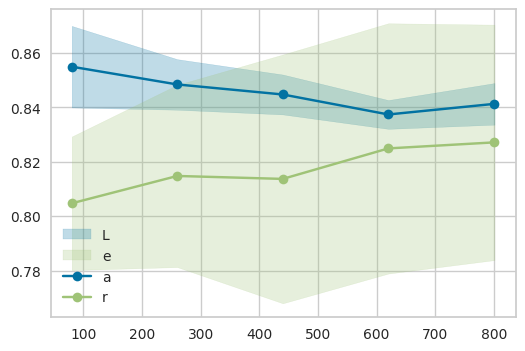

In [220]:
print("Overfitting and Underfitting.")
from yellowbrick.model_selection import (LearningCurve)
fig, ax = plt.subplots(figsize=(6,4))
lc = LearningCurve(ExtraTreesClassifier(n_estimators=20, criterion='gini', random_state=0,max_depth=5,max_leaf_nodes=30,min_samples_split= 8),
                  cv=10)
lc.fit(x,y)
ax.legend("Learning Curve for Random Forest Model.")

Validation Curve for Random Forest - max depth inspect.


[Text(0.5, 0, 'max_depth'), Text(0, 0.5, 'score')]

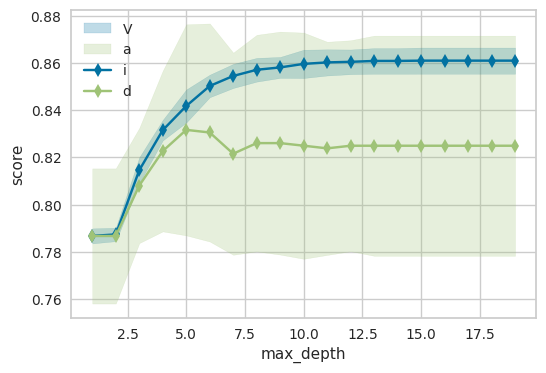

In [221]:
print("Validation Curve for Random Forest - max depth inspect.")
from yellowbrick.model_selection import (ValidationCurve)
fig, ax = plt.subplots(figsize=(6,4))
vc = ValidationCurve(ExtraTreesClassifier(n_estimators=20, criterion='gini', random_state=0,max_depth=5,max_leaf_nodes=30,min_samples_split= 8),
                  param_name = 'max_depth', param_range =np.arange(1,20),cv=10, n_jobs= -1)
vc.fit(x,y)
ax.legend("Vaidation Curve for Random Forest Model - max depth influence.")
vc.ax.set(
xlabel='max_depth', ylabel='score')

Overfitting and Underfitting.


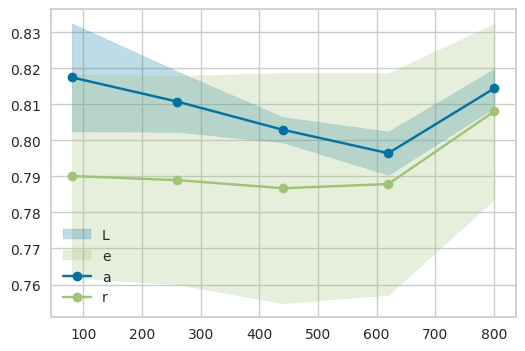

In [222]:
print("Overfitting and Underfitting.")
from yellowbrick.model_selection import (LearningCurve)
fig, ax = plt.subplots(figsize=(6,4))
lc = LearningCurve(ExtraTreesClassifier(n_estimators=20, criterion='gini', random_state=0,max_depth=3,max_leaf_nodes=30,min_samples_split= 8),
                  cv=10)
lc.fit(x,y)
ax.legend("Learning Curve for Random Forest Model.")

In [223]:
print("Training and predicting from selected and improved model.")
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(bootstrap=False, n_estimators=100, random_state=0, criterion='gini', max_depth=3, 
          min_samples_split=10, max_features=10, min_samples_leaf=10)

rf_model.fit(x,y)

Training and predicting from selected and improved model.


RandomForestClassifier(bootstrap=False, max_depth=3, max_features=10,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=0)

In [224]:
rf_model.score(x,y)

0.8327721661054994

In [225]:
Test = sc.fit_transform(Test)
Test1 = pd.read_csv("../input/titanic/test.csv")

output = pd.DataFrame({"PassengerId": IDcolumn, "Survived":rf_model.predict(Test)})
output.PassengerId = output.PassengerId.astype(int)
output.Survived = output.Survived.astype(int)

output.to_csv("TitanicSubmission.csv", index=False)
print("Your submission was successfully saved!")
output.head(10)

Your submission was successfully saved!


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
